In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv
from matplotlib.colors import Normalize


## この下で、必要な関数を定義する
Fzとαを解析的に定義

In [2]:
#〇〇anは使っているから〇〇anfにしている
def rbyA(A):
    r = -np.log(A)
    return r

def Fzanf(A):
    r = rbyA(A)
    Fz = np.exp(-1+np.log(1.5))*np.exp(-0.5*np.log(r))
    return Fz

def dFzdAanf(A):
    r = rbyA(A)
    d = np.exp(-1 + np.log(1.5))*np.exp(-0.5*np.log(r))*(-0.5/r)*(-1/A)
    return d

def rbyB(B):
    r = 0.5*np.log(2) - np.log(B)
    return r

def alphaanf(B):
    r = rbyB(B)
    alpha = 1 - np.exp(-(1 + 0.5*np.log(r) - r - np.log(1.5)))
    return alpha

def dalphadBanf(B):
    r =rbyB(B)
    d = ((0.5/r) - 1)*np.exp(-(1 + 0.5*np.log(r) - r - np.log(1.5)))*(-1/B)
    return d

## ここからReconstructionに必要なパラメータを定義する。
### まず、x方向とy方向にグリッドを作成し、二次元平面にメッシュを張ってA,Bx,などを計算する。
### そして、知っている解析解から計算できるx,y各方向への微分を、必要な分だけ計算し、最終的なReconstructionで使用するパラメータすべての解析解を計算する。
### 最後に、Reconstructionの関数に突っ込むためのobsの値を解析解から代入し、x方向への1次元配列として（見かけの）観測値を得る。

In [3]:
#Analytical solutions-------------------------------------------------------------------------------
nx = 1000
ny = 1001
ycenter = int((ny-1)/2)
deltay = 0.6/(ny-1)
deltax = 1.0/nx

xan = np.linspace(1,2,nx)
yan = np.linspace(0.2,0.8,ny)
Xan,Yan = np.meshgrid(xan,yan)
Ran = np.sqrt(Xan**2 + Yan**2)
    
Aan = np.exp(-Ran)
Bxan = -(Yan/Ran)*np.exp(-Ran)
Byan =  (Xan/Ran)*np.exp(-Ran)
Bzan = np.exp(-Ran)
Ban = np.sqrt(2)*np.exp(-Ran)#実際にはBx,By,Bzから求める
Fzan = np.exp(-1+np.log(1.5))*np.exp(-0.5*np.log(Ran))#実際にはalphaとBzから求める 
alphaan = 1.0 - np.exp(-(1.0 + 0.5*np.log(Ran) - Ran - np.log(1.5)))
    
#x方向への微分の解析解
delBxdelxan = (Xan*Yan*(Ran+1)*np.exp(-Ran))/(Ran**3)
del2Adelx2an = (np.exp(-Ran)/Ran)*((Xan**2/(Ran**2))*(Ran+1) - 1)
delBdelxan = -np.sqrt(2)*Xan*np.exp(-Ran)/Ran
    
#y方向への微分の解析解
del2Adely2an = (np.exp(-Ran)/Ran)*((Yan**2/(Ran**2))*(Ran+1) - 1)
delBzdelyan = -(Yan/Ran)*np.exp(-Ran)
#----------------------------------------------------------------------------------------------------

Aobs = Aan[ycenter,:]
Bxobs = Bxan[ycenter,:]
Byobs = Byan[ycenter,:]
Bzobs = Bzan[ycenter,:]
Bobs = Ban[ycenter,:]
alphaobs = alphaan[ycenter,:]
Fzobs = Fzan[ycenter,:]
dFzdAobs = dFzdAanf(Aan[ycenter,:])
dalphadBobs = dalphadBanf(Ban[ycenter,:])

def w(y):
    w = 1 - (1/3)*(y/ycenter)
    return w




## この下に、実際にReconstructionを行う関数を定義してある
### 与える引数はグリッド数と、A,Bx,By,Bz,B,Fz,dFzdA,dαdBの観測値（y=0.5の軌道上での値）
最初に、必要な配列を定義する。途中で必要になるx方向への微分の配列、スムージングの影響で一度何かに格納する必要があるA,Bx,By,Bz、各ステップでの計算結果を入れておく"rec"の配列、そして途中で必要な行列の定義をしている。"rec"の配列に初期値を入れて前準備は完了。

### 次にループ処理を行う。
ループの前に（見かけの）観測値である"obs"の変数を"prev"の変数に入れる。この"prev"の変数は「前のステップでのパラメータ」を表している（つもり）。
そのパラメータから中央差分を用いてx方向への微分のパラメータ3つを計算するが、ここで**端の値も計算し、それにスムージングをかけ、さらに端を境界条件で補っている。**
次にその微分を用いて行列計算のためのYやMの要素を計算する。Mの逆行列を計算して連立方程式を解いてy方向への微分のパラメータ2つを得ることができる。**ここのy方向への微分にもスムージングと境界条件を適用している。**そこからテイラー展開の式によってA,Bx,Bzの値を更新できる。更新したパラメータは、**スムージングをかける→再び端の値を補う**、という順番で滑らかにしている。
Byに関しては更新されたAの値の微分値を中央差分で取って値を更新している。Bは三方向の値から求められて、αとFzは関数があるので（更新された）AとBを用いて求められる（これはそれぞれの微分も同様）。(**太字**部分は前回からの変更点です）
###  ループの最後に
"rec"の配列に更新されたパラメータを入れ込み、次のステップで使えるように更新した値を"prev"の変数に入れる。これでループが終わり、更新された値を"prev"として同じ計算を繰り返す。

#### ループ変数jは1から始めていることに注意

In [4]:
def reconstrction(Nx,Ny,Aobs,Bxobs,Byobs,Bzobs,alphapobs,Fzobs):
    Lx = Nx-1
    Ly = Ny-1
    Bobs = np.sqrt(Bxobs**2 + Byobs**2 + Bzobs**2)

    #パラメータ設定-
    delBxdelxtmp = np.zeros((Nx))
    del2Adelx2tmp = np.zeros((Nx))
    delBdelxtmp = np.zeros((Nx))
    Apn = np.zeros((Nx))
    Bxpn = np.zeros((Nx))
    Bzpn = np.zeros((Nx))
    Bypn = np.zeros((Nx))
    
    Arec = np.empty((Ny,Nx))
    Bxrec = np.empty((Ny,Nx))
    Byrec = np.empty((Ny,Nx))
    Bzrec = np.empty((Ny,Nx))
    Brec = np.empty((Ny,Nx))
    alpharec = np.empty((Ny,Nx))
    Fzrec = np.empty((Ny,Nx))
    delBxdelxrec = np.empty((Ny,Nx))
    del2Adelx2rec = np.empty((Ny,Nx))
    delBdelxrec = np.empty((Ny,Nx))
    del2Adely2rec = np.empty((Ny,Nx))
    delBzdelyrec = np.empty((Ny,Nx))
    
    Arec[ycenter,:] = Aobs
    Bxrec[ycenter,:] = Bxobs
    Byrec[ycenter,:] = Byobs
    Bzrec[ycenter,:] = Bzobs
    Brec[ycenter,:] = Bobs
    alpharec[ycenter,:] = alphaobs
    Fzrec[ycenter,:] = Fzobs
    
    Mtmp = np.empty((Nx,2,2))
    Mtmpinv11 = np.empty((Nx))
    Mtmpinv12 = np.empty((Nx))
    Mtmpinv21 = np.empty((Nx))
    Mtmpinv22 = np.empty((Nx))
    
    i = np.arange(1,Lx)#x方向のグリッドの端0とLxを除いた分の配列
    
    Aprev = Aobs
    Bxprev = Bxobs
    Byprev = Byobs
    Bzprev = Bzobs
    Bprev = Bobs
    alphaprev = alphaobs
    Fzprev = Fzobs
    dFzdAprev = dFzdAanf(Aobs)
    dalphadBprev = dalphadBanf(Bobs)
    
    
    for j in range(1,ycenter-1):#j = 1~ycenter,stepnumber
        #x-difference
        delBxdelxtmp[i] = (Bxprev[i+1] - Bxprev[i-1])/(2*deltax)
        del2Adelx2tmp[i] = (Aprev[i+1] - 2*Aprev[i] + Aprev[i-1])/(deltax**2)
        delBdelxtmp[i] = (Bprev[i+1] - Bprev[i-1])/(2*deltax)
        
        delBxdelxtmp[0] = (1/6)*(-11*Bxprev[0] + 18*Bxprev[1] - 9*Bxprev[2] + 2*Bxprev[3])/deltax
        delBxdelxtmp[Lx] = (1/6)*(11*Bxprev[Lx] - 18*Bxprev[Lx-1] + 9*Bxprev[Lx-2] - 2*Bxprev[Lx-3])/deltax
        del2Adelx2tmp[0] = (2*Aprev[0] - 5*Aprev[1] + 4*Aprev[2] - Aprev[3])/(deltax**2)
        del2Adelx2tmp[Lx] = (2*Aprev[Lx] - 5*Aprev[Lx-1] + 4*Aprev[Lx-2] - Aprev[Lx-3])/(deltax**2)
        delBdelxtmp[0] = (1/6)*(-11*Bprev[0] + 18*Bprev[1] - 9*Bprev[2] + 2*Bprev[3])/deltax
        delBdelxtmp[Lx] = (1/6)*(11*Bprev[Lx] - 18*Bprev[Lx-1] + 9*Bprev[Lx-2] - 2*Bprev[Lx-3])/deltax
        
        #smoothing
        delBxdelxtmp[i] = w(j-1)*delBxdelxtmp[i] + (1/2)*(1-w(j-1))*(delBxdelxtmp[i-1]+delBxdelxtmp[i+1])
        del2Adelx2tmp[i] = w(j-1)*del2Adelx2tmp[i] + (1/2)*(1-w(j-1))*(del2Adelx2tmp[i-1]+del2Adelx2tmp[i+1])
        delBdelxtmp[i] = w(j-1)*delBdelxtmp[i] + (1/2)*(1-w(j-1))*(delBdelxtmp[i-1]+delBdelxtmp[i+1])
        
        #boundary condition
        delBxdelxtmp[0] = 4*delBxdelxtmp[1] - 6*delBxdelxtmp[2] + 4*delBxdelxtmp[3] - delBxdelxtmp[4]
        delBxdelxtmp[Lx] = 4*delBxdelxtmp[Lx-1] - 6*delBxdelxtmp[Lx-2] + 4*delBxdelxtmp[Lx-3] - delBxdelxtmp[Lx-4]
        del2Adelx2tmp[0] = 4*del2Adelx2tmp[1] - 6*del2Adelx2tmp[2] + 4*del2Adelx2tmp[3] - del2Adelx2tmp[4]
        del2Adelx2tmp[Lx] = 4*del2Adelx2tmp[Lx-1] - 6*del2Adelx2tmp[Lx-2] + 4*del2Adelx2tmp[Lx-3] - del2Adelx2tmp[Lx-4]
        delBdelxtmp[0] = 4*delBdelxtmp[1] - 6*delBdelxtmp[2] + 4*delBdelxtmp[3] - delBdelxtmp[4]
        delBdelxtmp[Lx] = 4*delBdelxtmp[Lx-1] - 6*delBdelxtmp[Lx-2] + 4*delBdelxtmp[Lx-3] - delBdelxtmp[Lx-4]  
        
        
        
        #Matrix
        Y1tmp = -(1-alphaprev)*del2Adelx2tmp - Byprev*dalphadBprev*delBdelxtmp - (Bxprev*Byprev/Bprev)*dalphadBprev*delBxdelxtmp - Bzprev*dFzdAprev
        Y2tmp = -(Byprev*Bzprev/Bprev)*dalphadBprev*delBxdelxtmp + Bxprev*dFzdAprev
        M11tmp = (1-alphaprev) - ((Bxprev**2)/Bprev)*dalphadBprev
        M12tmp = -(Bxprev*Bzprev/Bprev)*dalphadBprev
        M22tmp = (1-alphaprev) - ((Bzprev**2)/Bprev)*dalphadBprev
        
        Mtmp[:,0,0] = M11tmp[:]
        Mtmp[:,0,1] = M12tmp[:]
        Mtmp[:,1,0] = M12tmp[:]
        Mtmp[:,1,1] = M22tmp[:]
        
        Mtmpinv = np.linalg.inv(Mtmp)
        
        Mtmpinv11[:] = Mtmpinv[:,0,0]
        Mtmpinv12[:] = Mtmpinv[:,0,1]
        Mtmpinv21[:] = Mtmpinv[:,1,0]
        Mtmpinv22[:] = Mtmpinv[:,1,1]
        
        #y-difference
        del2Adely2tmp = Mtmpinv11*Y1tmp + Mtmpinv12*Y2tmp
        delBzdelytmp = Mtmpinv21*Y1tmp + Mtmpinv22*Y2tmp
        #smoothing
        del2Adely2tmp[i] = w(j-1)*del2Adely2tmp[i] + (1/2)*(1-w(j-1))*(del2Adely2tmp[i-1]+del2Adely2tmp[i+1])
        delBzdelytmp[i] = w(j-1)*delBzdelytmp[i] + (1/2)*(1-w(j-1))*(delBzdelytmp[i-1]+delBzdelytmp[i+1])
        #boundary condition
        delBzdelytmp[0] = 4*delBzdelytmp[1] - 6*delBzdelytmp[2] + 4*delBzdelytmp[3] - delBzdelytmp[4]
        delBzdelytmp[Lx] = 4*delBzdelytmp[Lx-1] - 6*delBzdelytmp[Lx-2] + 4*delBzdelytmp[Lx-3] - delBzdelytmp[Lx-4]
        del2Adely2tmp[0] = 4*del2Adely2tmp[1] - 6*del2Adely2tmp[2] + 4*del2Adely2tmp[3] - del2Adely2tmp[4]
        del2Adely2tmp[Lx] = 4*del2Adely2tmp[Lx-1] - 6*del2Adely2tmp[Lx-2] + 4*del2Adely2tmp[Lx-3] - del2Adely2tmp[Lx-4]
        
        
        Apn  = Aprev + deltay*Bxprev + 0.5*(deltay**2)*del2Adely2tmp
        Bxpn = Bxprev + deltay*del2Adely2tmp
        Bzpn = Bzprev + deltay*delBzdelytmp
        
        #boundary condition
        #Apn[0] = 4*Apn[1] - 6*Apn[2] + 4*Apn[3] - Apn[4]
        #Apn[Lx] = 4*Apn[Lx-1] - 6*Apn[Lx-2] + 4*Apn[Lx-3] - Apn[Lx-4]
        #Bxpn[0] = 4*Bxpn[1] - 6*Bxpn[2] + 4*Bxpn[3] - Bxpn[4]
        #Bxpn[Lx] = 4*Bxpn[Lx-1] - 6*Bxpn[Lx-2] + 4*Bxpn[Lx-3] - Bxpn[Lx-4]
        #Bzpn[0] = 4*Bzpn[1] - 6*Bzpn[2] + 4*Bzpn[3] - Bzpn[4]
        #Bzpn[Lx] = 4*Bzpn[Lx-1] - 6*Bzpn[Lx-2] + 4*Bzpn[Lx-3] - Bzpn[Lx-4]   
        
        #smoothing
        Apn[i] = w(j)*Apn[i] + (1/2)*(1-w(j))*(Apn[i-1]+Apn[i+1])
        Bxpn[i] = w(j)*Bxpn[i] + (1/2)*(1-w(j))*(Bxpn[i-1]+Bxpn[i+1])
        Bzpn[i] = w(j)*Bzpn[i] + (1/2)*(1-w(j))*(Bzpn[i-1]+Bzpn[i+1])
        
        #boundary condition
        Apn[0] = 4*Apn[1] - 6*Apn[2] + 4*Apn[3] - Apn[4]
        Apn[Lx] = 4*Apn[Lx-1] - 6*Apn[Lx-2] + 4*Apn[Lx-3] - Apn[Lx-4]
        Bxpn[0] = 4*Bxpn[1] - 6*Bxpn[2] + 4*Bxpn[3] - Bxpn[4]
        Bxpn[Lx] = 4*Bxpn[Lx-1] - 6*Bxpn[Lx-2] + 4*Bxpn[Lx-3] - Bxpn[Lx-4]
        Bzpn[0] = 4*Bzpn[1] - 6*Bzpn[2] + 4*Bzpn[3] - Bzpn[4]
        Bzpn[Lx] = 4*Bzpn[Lx-1] - 6*Bzpn[Lx-2] + 4*Bzpn[Lx-3] - Bzpn[Lx-4]  
        
        #By
        Bypn[i] = -(Apn[i+1] -Apn[i-1])/(2*deltax)
        #boundary condition
        Bypn[0] = 4*Bypn[1] - 6*Bypn[2] + 4*Bypn[3] - Bypn[4]
        Bypn[Lx] = 4*Bypn[Lx-1] - 6*Bypn[Lx-2] + 4*Bypn[Lx-3] - Bypn[Lx-4]
        #Smoothing
        Bypn[i] = w(j)*Bypn[i] + (1/2)*(1-w(j))*(Bypn[i-1]+Bypn[i+1])
        #boundary condition
        Bypn[0] = 4*Bypn[1] - 6*Bypn[2] + 4*Bypn[3] - Bypn[4]
        Bypn[Lx] = 4*Bypn[Lx-1] - 6*Bypn[Lx-2] + 4*Bypn[Lx-3] - Bypn[Lx-4]
        
        Bpn = np.sqrt(Bxpn**2 + Bypn**2 + Bzpn**2)
        alphapn = alphaanf(Bpn)
        Fzpn = (1 - alphapn)*Bzpn
        
        
        Arec[ycenter+j,:] = Apn[:]
        Bxrec[ycenter+j,:] = Bxpn[:]
        Byrec[ycenter+j,:] = Bypn[:]
        Bzrec[ycenter+j,:] = Bzpn[:]
        Brec[ycenter+j,:]  = Bpn[:]
        alpharec[ycenter+j,:] = alphapn[:]
        Fzrec[ycenter+j,:] = Fzpn[:]
        #各方向への差分で求めた微分の値は、その場での値
        delBxdelxrec[ycenter+j-1,:] = delBxdelxtmp[:] 
        del2Adelx2rec[ycenter+j-1,:] = del2Adelx2tmp[:]
        delBdelxrec[ycenter+j-1,:] = delBdelxtmp[:]
        del2Adely2rec[ycenter+j-1,:] = del2Adely2tmp[:] 
        delBzdelyrec[ycenter+j-1,:] = delBzdelytmp[:] 
        
        Aprev = Apn
        Bxprev = Bxpn
        Byprev = Bypn
        Bzprev = Bzpn
        Bprev = Bpn
        alphaprev = alphapn
        Fzprev = Fzpn
        dFzdAprev = dFzdAanf(Apn)
        dalphadBprev = dalphadBanf(Bpn)
#繰り返しここまで-------------------------------------------------------------------    

    return Arec,Bxrec,Byrec,Bzrec,Brec,alpharec,Fzrec,delBxdelxrec,del2Adelx2rec,delBdelxrec,del2Adely2rec,delBzdelyrec



    

## まずは普通の場合で実行してみる

In [5]:
conc = reconstrction(nx,ny,Aobs,Bxobs,Byobs,Bzobs,alphaobs,Fzobs)

C:\Users\Ryoya Shimada\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
C:\Users\Ryoya Shimada\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log


In [6]:
Arec = conc[0]
Bxrec = conc[1]
Byrec = conc[2]
Bzrec = conc[3]
Brec = conc[4]
alpharec = conc[5]
Fzrec = conc[6]
delBxdelxrec = conc[7]
del2Adelx2rec = conc[8]
delBdelxrec = conc[9]
del2Adely2rec = conc[10]
delBzdelyrec = conc[11]


## Reconstructionの結果を、解析解に対してプロットしてみる。
x方向の微分、y方向の微分、それ以外のパラメータという順番になっている。

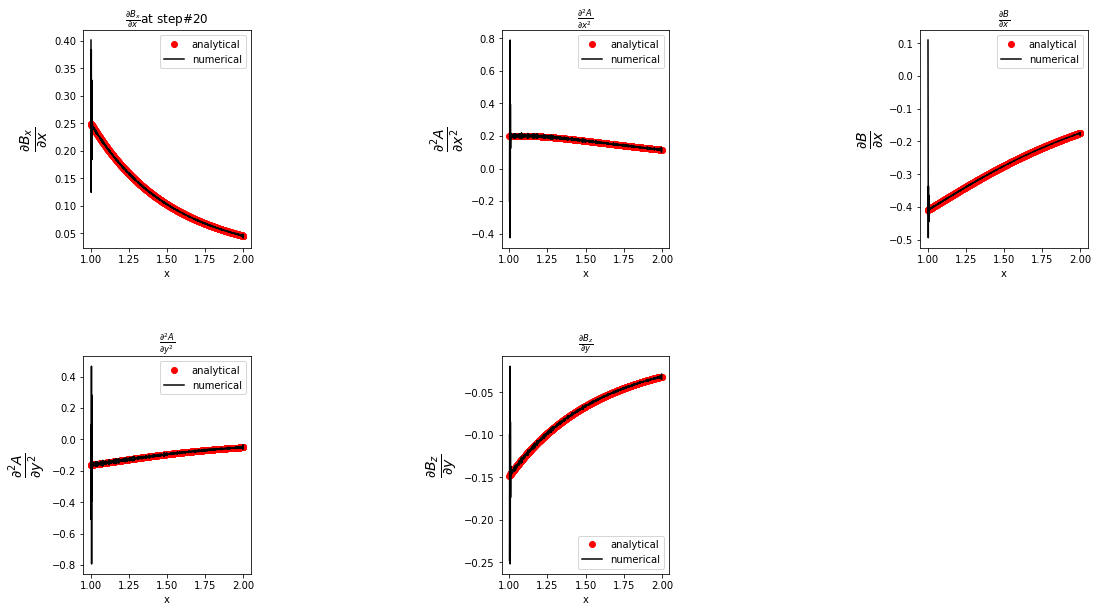

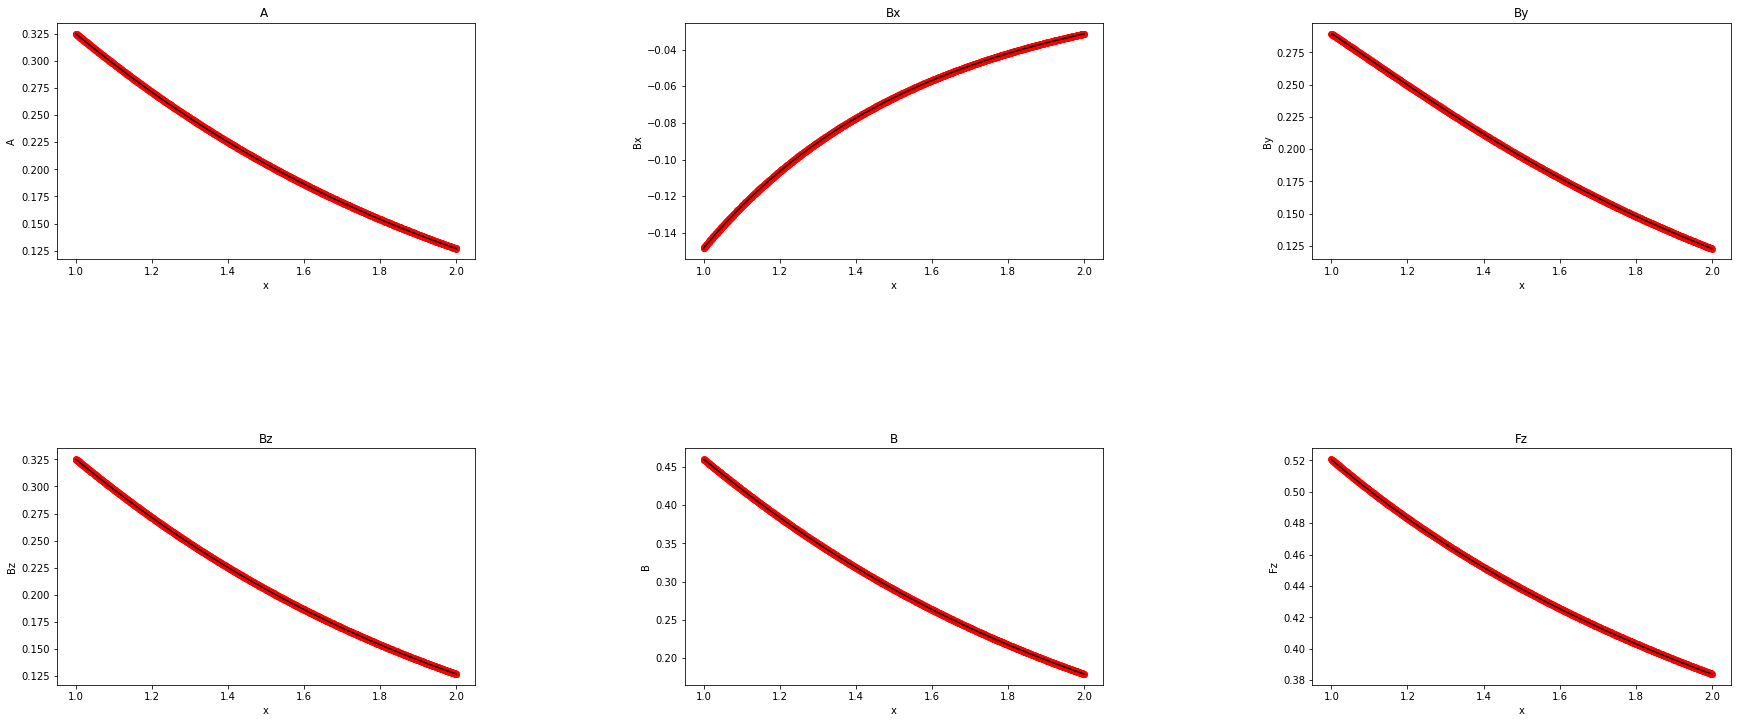

In [7]:
#x方向の微分の確認
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ystep=20

ax1.plot(Xan[500,1:998],delBxdelxan[ycenter+ystep,1:998],'ro',label='analytical')
ax1.plot(Xan[500,1:998],delBxdelxrec[ycenter+ystep,1:998],'k',label='numerical')
ax1.set_xlabel('x')
ax1.set_ylabel(r"$ \frac{\partial B_x}{\partial x} $",fontsize=20)
ax1.set_title(r"$ \frac{\partial B_x}{\partial x} $" 'at step#20')
ax1.legend()

ax2.plot(Xan[500,1:998],del2Adelx2an[ycenter+ystep,1:998],'ro',label='analytical')
ax2.plot(Xan[500,1:998],del2Adelx2rec[ycenter+ystep,1:998],'k',label='numerical')
ax2.set_xlabel('x')
ax2.set_ylabel(r"$ \frac{\partial^2 A}{\partial x^2} $",fontsize=20)
ax2.set_title(r"$ \frac{\partial^2 A}{\partial x^2} $" )
ax2.legend()

ax3.plot(Xan[500,1:998],delBdelxan[ycenter+ystep,1:998],'ro',label='analytical')
ax3.plot(Xan[500,1:998],delBdelxrec[ycenter+ystep,1:998],'k',label='numerical')
ax3.set_xlabel('x')
ax3.set_ylabel(r"$ \frac{\partial B}{\partial x} $",fontsize=20)
ax3.set_title(r"$ \frac{\partial B}{\partial x} $" )
ax3.legend()

ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

ax4.plot(Xan[500,1:998],del2Adely2an[ycenter+ystep,1:998],'ro',label='analytical')
ax4.plot(Xan[500,1:998],del2Adely2rec[ycenter+ystep,1:998],'k',label='numerical')
ax4.set_xlabel('x')
ax4.set_ylabel(r"$ \frac{\partial^2 A}{\partial y^2} $",fontsize=20)
ax4.set_title(r"$ \frac{\partial^2 A}{\partial y^2} $" )
ax4.legend()

ax5.plot(Xan[500,1:998],delBzdelyan[ycenter+ystep,1:998],'ro',label='analytical')
ax5.plot(Xan[500,1:998],delBzdelyrec[ycenter+ystep,1:998],'k',label='numerical')
ax5.set_xlabel('x')
ax5.set_ylabel(r"$ \frac{\partial B_z}{\partial y} $",fontsize=20)
ax5.set_title(r"$ \frac{\partial B_z}{\partial y} $" )
ax5.legend()

fig2 = plt.figure(figsize=(30,20))
ax1 = fig2.add_subplot(331)
ax2 = fig2.add_subplot(332)
ax3 = fig2.add_subplot(333)
ax4 = fig2.add_subplot(334)
ax5 = fig2.add_subplot(335)
ax6 = fig2.add_subplot(336)

ax1.plot(Xan[500,:],Aan[ycenter+ystep,:],'ro',label='analytical')
ax1.plot(Xan[500,:],Arec[ycenter+ystep,:],'k',label='numerical')
ax1.set_xlabel('x')
ax1.set_ylabel('A')
ax1.set_title('A ')

ax2.plot(Xan[500,:],Bxan[ycenter+ystep,:],'ro',label='analytical')
ax2.plot(Xan[500,:],Bxrec[ycenter+ystep,:],'k',label='numerical')
ax2.set_xlabel('x')
ax2.set_ylabel('Bx')
ax2.set_title('Bx')

ax3.plot(Xan[500,:],Byan[ycenter+ystep,:],'ro',label='analytical')
ax3.plot(Xan[500,:],Byrec[ycenter+ystep,:],'k',label='numerical')
ax3.set_xlabel('x')
ax3.set_ylabel('By')
ax3.set_title('By')

ax4.plot(Xan[500,:],Bzan[ycenter+ystep,:],'ro',label='analytical')
ax4.plot(Xan[500,:],Bzrec[ycenter+ystep,:],'k',label='numerical')
ax4.set_xlabel('x')
ax4.set_ylabel('Bz')
ax4.set_title('Bz')

ax5.plot(Xan[500,:],Ban[ycenter+ystep,:],'ro',label='analytical')
ax5.plot(Xan[500,:],Brec[ycenter+ystep,:],'k',label='numerical')
ax5.set_xlabel('x')
ax5.set_ylabel('B')
ax5.set_title('B')

ax6.plot(Xan[500,:],Fzan[ycenter+ystep,:],'ro',label='analytical')
ax6.plot(Xan[500,:],Fzrec[ycenter+ystep,:],'k',label='numerical')
ax6.set_xlabel('x')
ax6.set_ylabel('Fz')
ax6.set_title('Fz')

fig2.subplots_adjust(wspace=0.5,hspace=0.8)

fig.subplots_adjust(wspace=1.5,hspace=0.5)

## この下では、スムージングのやり方を変えたreconstructionの関数を定義する。とりあえずは重み関数を使うのではなく単純な三点平均をとってみる。

In [8]:
def reconstrction_3point(Nx,Ny,Aobs,Bxobs,Byobs,Bzobs,alphapobs,Fzobs):
    Lx = Nx-1
    Ly = Ny-1
    Bobs = np.sqrt(Bxobs**2 + Byobs**2 + Bzobs**2)

    #パラメータ設定-
    delBxdelxtmp = np.zeros((Nx))
    del2Adelx2tmp = np.zeros((Nx))
    delBdelxtmp = np.zeros((Nx))
    Apn = np.zeros((Nx))
    Bxpn = np.zeros((Nx))
    Bzpn = np.zeros((Nx))
    Bypn = np.zeros((Nx))
    
    Arec = np.empty((Ny,Nx))
    Bxrec = np.empty((Ny,Nx))
    Byrec = np.empty((Ny,Nx))
    Bzrec = np.empty((Ny,Nx))
    Brec = np.empty((Ny,Nx))
    alpharec = np.empty((Ny,Nx))
    Fzrec = np.empty((Ny,Nx))
    delBxdelxrec = np.empty((Ny,Nx))
    del2Adelx2rec = np.empty((Ny,Nx))
    delBdelxrec = np.empty((Ny,Nx))
    del2Adely2rec = np.empty((Ny,Nx))
    delBzdelyrec = np.empty((Ny,Nx))
    
    Arec[ycenter,:] = Aobs
    Bxrec[ycenter,:] = Bxobs
    Byrec[ycenter,:] = Byobs
    Bzrec[ycenter,:] = Bzobs
    Brec[ycenter,:] = Bobs
    alpharec[ycenter,:] = alphaobs
    Fzrec[ycenter,:] = Fzobs
    
    Mtmp = np.empty((Nx,2,2))
    Mtmpinv11 = np.empty((Nx))
    Mtmpinv12 = np.empty((Nx))
    Mtmpinv21 = np.empty((Nx))
    Mtmpinv22 = np.empty((Nx))
    
    i = np.arange(1,Lx)#x方向のグリッドの端0とLxを除いた分の配列
    
    Aprev = Aobs
    Bxprev = Bxobs
    Byprev = Byobs
    Bzprev = Bzobs
    Bprev = Bobs
    alphaprev = alphaobs
    Fzprev = Fzobs
    dFzdAprev = dFzdAanf(Aobs)
    dalphadBprev = dalphadBanf(Bobs)
    
    
    for j in range(1,ycenter-1):#j = 1~ycenter,stepnumber
        #x-difference
        delBxdelxtmp[i] = (Bxprev[i+1] - Bxprev[i-1])/(2*deltax)
        del2Adelx2tmp[i] = (Aprev[i+1] - 2*Aprev[i] + Aprev[i-1])/(deltax**2)
        delBdelxtmp[i] = (Bprev[i+1] - Bprev[i-1])/(2*deltax)
        
        delBxdelxtmp[0] = (1/6)*(-11*Bxprev[0] + 18*Bxprev[1] - 9*Bxprev[2] + 2*Bxprev[3])/deltax
        delBxdelxtmp[Lx] = (1/6)*(11*Bxprev[Lx] - 18*Bxprev[Lx-1] + 9*Bxprev[Lx-2] - 2*Bxprev[Lx-3])/deltax
        del2Adelx2tmp[0] = (2*Aprev[0] - 5*Aprev[1] + 4*Aprev[2] - Aprev[3])/(deltax**2)
        del2Adelx2tmp[Lx] = (2*Aprev[Lx] - 5*Aprev[Lx-1] + 4*Aprev[Lx-2] - Aprev[Lx-3])/(deltax**2)
        delBdelxtmp[0] = (1/6)*(-11*Bprev[0] + 18*Bprev[1] - 9*Bprev[2] + 2*Bprev[3])/deltax
        delBdelxtmp[Lx] = (1/6)*(11*Bprev[Lx] - 18*Bprev[Lx-1] + 9*Bprev[Lx-2] - 2*Bprev[Lx-3])/deltax
        
        #smoothing
        delBxdelxtmp[i] = (1/3)*(delBxdelxtmp[i] + delBxdelxtmp[i-1] + delBxdelxtmp[i+1])
        del2Adelx2tmp[i] = (1/3)*(del2Adelx2tmp[i] + del2Adelx2tmp[i-1] + del2Adelx2tmp[i+1])
        delBdelxtmp[i] = (1/3)*(delBdelxtmp[i] + delBdelxtmp[i-1] + delBdelxtmp[i+1])
        
        #boundary condition
        delBxdelxtmp[0] = 4*delBxdelxtmp[1] - 6*delBxdelxtmp[2] + 4*delBxdelxtmp[3] - delBxdelxtmp[4]
        delBxdelxtmp[Lx] = 4*delBxdelxtmp[Lx-1] - 6*delBxdelxtmp[Lx-2] + 4*delBxdelxtmp[Lx-3] - delBxdelxtmp[Lx-4]
        del2Adelx2tmp[0] = 4*del2Adelx2tmp[1] - 6*del2Adelx2tmp[2] + 4*del2Adelx2tmp[3] - del2Adelx2tmp[4]
        del2Adelx2tmp[Lx] = 4*del2Adelx2tmp[Lx-1] - 6*del2Adelx2tmp[Lx-2] + 4*del2Adelx2tmp[Lx-3] - del2Adelx2tmp[Lx-4]
        delBdelxtmp[0] = 4*delBdelxtmp[1] - 6*delBdelxtmp[2] + 4*delBdelxtmp[3] - delBdelxtmp[4]
        delBdelxtmp[Lx] = 4*delBdelxtmp[Lx-1] - 6*delBdelxtmp[Lx-2] + 4*delBdelxtmp[Lx-3] - delBdelxtmp[Lx-4]  
        
        
        
        #Matrix
        Y1tmp = -(1-alphaprev)*del2Adelx2tmp - Byprev*dalphadBprev*delBdelxtmp - (Bxprev*Byprev/Bprev)*dalphadBprev*delBxdelxtmp - Bzprev*dFzdAprev
        Y2tmp = -(Byprev*Bzprev/Bprev)*dalphadBprev*delBxdelxtmp + Bxprev*dFzdAprev
        M11tmp = (1-alphaprev) - ((Bxprev**2)/Bprev)*dalphadBprev
        M12tmp = -(Bxprev*Bzprev/Bprev)*dalphadBprev
        M22tmp = (1-alphaprev) - ((Bzprev**2)/Bprev)*dalphadBprev
        
        Mtmp[:,0,0] = M11tmp[:]
        Mtmp[:,0,1] = M12tmp[:]
        Mtmp[:,1,0] = M12tmp[:]
        Mtmp[:,1,1] = M22tmp[:]
        
        Mtmpinv = np.linalg.inv(Mtmp)
        
        Mtmpinv11[:] = Mtmpinv[:,0,0]
        Mtmpinv12[:] = Mtmpinv[:,0,1]
        Mtmpinv21[:] = Mtmpinv[:,1,0]
        Mtmpinv22[:] = Mtmpinv[:,1,1]
        
        #y-difference
        del2Adely2tmp = Mtmpinv11*Y1tmp + Mtmpinv12*Y2tmp
        delBzdelytmp = Mtmpinv21*Y1tmp + Mtmpinv22*Y2tmp
        #smoothing
        del2Adely2tmp[i] = (1/3)*(del2Adely2tmp[i] + del2Adely2tmp[i-1] + del2Adely2tmp[i+1])
        delBzdelytmp[i] = (1/3)*(delBzdelytmp[i] + delBzdelytmp[i-1] + delBzdelytmp[i+1])
        #boundary condition
        delBzdelytmp[0] = 4*delBzdelytmp[1] - 6*delBzdelytmp[2] + 4*delBzdelytmp[3] - delBzdelytmp[4]
        delBzdelytmp[Lx] = 4*delBzdelytmp[Lx-1] - 6*delBzdelytmp[Lx-2] + 4*delBzdelytmp[Lx-3] - delBzdelytmp[Lx-4]
        del2Adely2tmp[0] = 4*del2Adely2tmp[1] - 6*del2Adely2tmp[2] + 4*del2Adely2tmp[3] - del2Adely2tmp[4]
        del2Adely2tmp[Lx] = 4*del2Adely2tmp[Lx-1] - 6*del2Adely2tmp[Lx-2] + 4*del2Adely2tmp[Lx-3] - del2Adely2tmp[Lx-4]
        
        
        Apn  = Aprev + deltay*Bxprev + 0.5*(deltay**2)*del2Adely2tmp
        Bxpn = Bxprev + deltay*del2Adely2tmp
        Bzpn = Bzprev + deltay*delBzdelytmp
        
        #boundary conditionで0と999を補う
        #Apn[0] = 4*Apn[1] - 6*Apn[2] + 4*Apn[3] - Apn[4]
        #Apn[Lx] = 4*Apn[Lx-1] - 6*Apn[Lx-2] + 4*Apn[Lx-3] - Apn[Lx-4]
        #Bxpn[0] = 4*Bxpn[1] - 6*Bxpn[2] + 4*Bxpn[3] - Bxpn[4]
        #Bxpn[Lx] = 4*Bxpn[Lx-1] - 6*Bxpn[Lx-2] + 4*Bxpn[Lx-3] - Bxpn[Lx-4]
        #Bzpn[0] = 4*Bzpn[1] - 6*Bzpn[2] + 4*Bzpn[3] - Bzpn[4]
        #Bzpn[Lx] = 4*Bzpn[Lx-1] - 6*Bzpn[Lx-2] + 4*Bzpn[Lx-3] - Bzpn[Lx-4]   
        
        #smoothing
        Apn[i] = (1/3)*(Apn[i] + Apn[i-1] + Apn[i+1])
        Bxpn[i] = (1/3)*(Bxpn[i] + Bxpn[i-1] + Bxpn[i+1])
        Bzpn[i] = (1/3)*(Bzpn[i] + Bzpn[i-1] + Bzpn[i+1])
        
        #boundary condition
        Apn[0] = 4*Apn[1] - 6*Apn[2] + 4*Apn[3] - Apn[4]
        Apn[Lx] = 4*Apn[Lx-1] - 6*Apn[Lx-2] + 4*Apn[Lx-3] - Apn[Lx-4]
        Bxpn[0] = 4*Bxpn[1] - 6*Bxpn[2] + 4*Bxpn[3] - Bxpn[4]
        Bxpn[Lx] = 4*Bxpn[Lx-1] - 6*Bxpn[Lx-2] + 4*Bxpn[Lx-3] - Bxpn[Lx-4]
        Bzpn[0] = 4*Bzpn[1] - 6*Bzpn[2] + 4*Bzpn[3] - Bzpn[4]
        Bzpn[Lx] = 4*Bzpn[Lx-1] - 6*Bzpn[Lx-2] + 4*Bzpn[Lx-3] - Bzpn[Lx-4]  
        
        #By
        Bypn[i] = -(Apn[i+1] -Apn[i-1])/(2*deltax)
        #boundary condition
        Bypn[0] = 4*Bypn[1] - 6*Bypn[2] + 4*Bypn[3] - Bypn[4]
        Bypn[Lx] = 4*Bypn[Lx-1] - 6*Bypn[Lx-2] + 4*Bypn[Lx-3] - Bypn[Lx-4]
        #Smoothing
        Bypn[i] = (1/3)*(Bypn[i] + Bypn[i-1] + Bypn[i+1])
        #boundary condition
        Bypn[0] = 4*Bypn[1] - 6*Bypn[2] + 4*Bypn[3] - Bypn[4]
        Bypn[Lx] = 4*Bypn[Lx-1] - 6*Bypn[Lx-2] + 4*Bypn[Lx-3] - Bypn[Lx-4]
        
        Bpn = np.sqrt(Bxpn**2 + Bypn**2 + Bzpn**2)
        alphapn = alphaanf(Bpn)
        Fzpn = (1 - alphapn)*Bzpn
        
        
        Arec[ycenter+j,:] = Apn[:]
        Bxrec[ycenter+j,:] = Bxpn[:]
        Byrec[ycenter+j,:] = Bypn[:]
        Bzrec[ycenter+j,:] = Bzpn[:]
        Brec[ycenter+j,:]  = Bpn[:]
        alpharec[ycenter+j,:] = alphapn[:]
        Fzrec[ycenter+j,:] = Fzpn[:]
        #各方向への差分で求めた微分の値は、その場での値
        delBxdelxrec[ycenter+j-1,:] = delBxdelxtmp[:] 
        del2Adelx2rec[ycenter+j-1,:] = del2Adelx2tmp[:]
        delBdelxrec[ycenter+j-1,:] = delBdelxtmp[:]
        del2Adely2rec[ycenter+j-1,:] = del2Adely2tmp[:] 
        delBzdelyrec[ycenter+j-1,:] = delBzdelytmp[:] 
        
        Aprev = Apn
        Bxprev = Bxpn
        Byprev = Bypn
        Bzprev = Bzpn
        Bprev = Bpn
        alphaprev = alphapn
        Fzprev = Fzpn
        dFzdAprev = dFzdAanf(Apn)
        dalphadBprev = dalphadBanf(Bpn)
#繰り返しここまで-------------------------------------------------------------------    

    return Arec,Bxrec,Byrec,Bzrec,Brec,alpharec,Fzrec,delBxdelxrec,del2Adelx2rec,delBdelxrec,del2Adely2rec,delBzdelyrec



    

In [9]:
conc2 = reconstrction_3point(nx,ny,Aobs,Bxobs,Byobs,Bzobs,alphaobs,Fzobs)

Arec_3point = conc2[0]
Bxrec_3point = conc2[1]
Byrec_3point = conc2[2]
Bzrec_3point = conc2[3]
Brec_3point = conc2[4]
alpharec_3point = conc2[5]
Fzrec_3point = conc2[6]
delBxdelxrec_3point = conc2[7]
del2Adelx2rec_3point = conc2[8]
delBdelxrec_3point = conc2[9]
del2Adely2rec_3point = conc2[10]
delBzdelyrec_3point = conc2[11]


C:\Users\Ryoya Shimada\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
C:\Users\Ryoya Shimada\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log


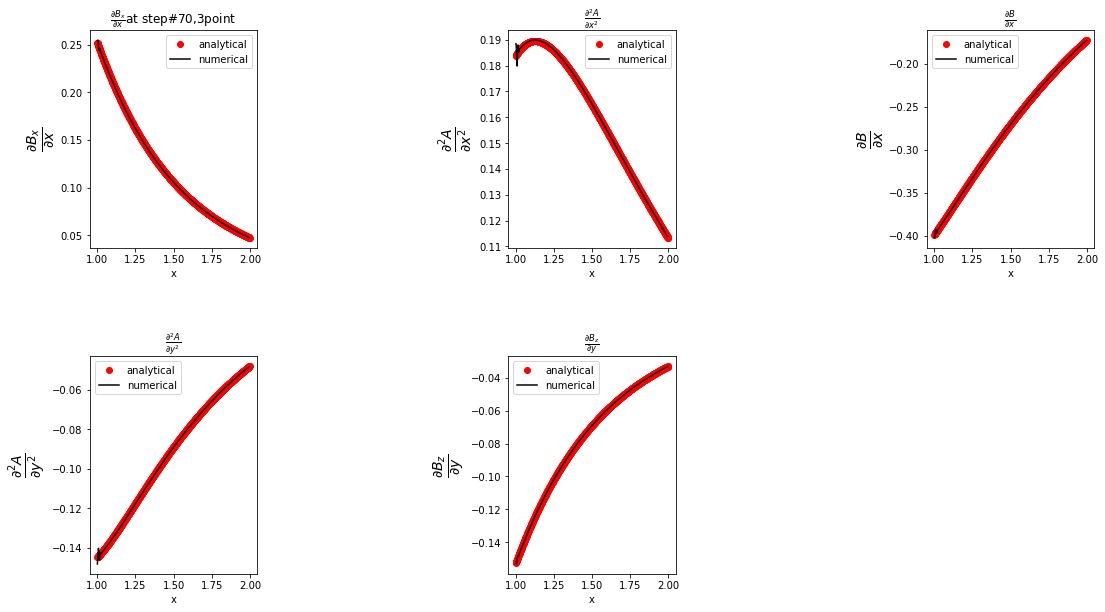

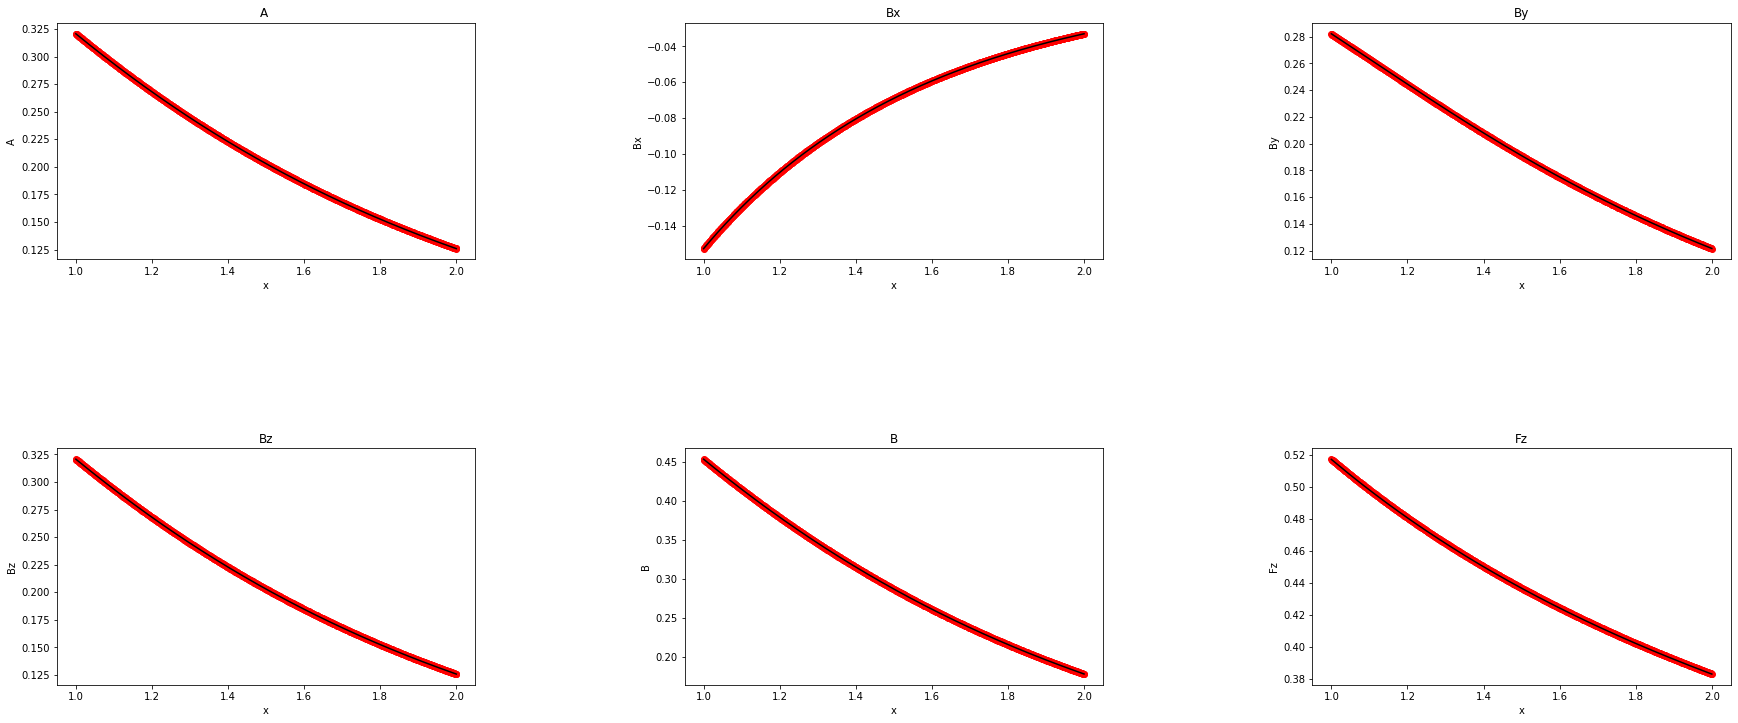

In [10]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ystep=70

ax1.plot(Xan[500,1:998],delBxdelxan[ycenter+ystep,1:998],'ro',label='analytical')
ax1.plot(Xan[500,1:998],delBxdelxrec_3point[ycenter+ystep,1:998],'k',label='numerical')
ax1.set_xlabel('x')
ax1.set_ylabel(r"$ \frac{\partial B_x}{\partial x} $",fontsize=20)
ax1.set_title(r"$ \frac{\partial B_x}{\partial x} $" 'at step#70,3point')
ax1.legend()

ax2.plot(Xan[500,1:998],del2Adelx2an[ycenter+ystep,1:998],'ro',label='analytical')
ax2.plot(Xan[500,1:998],del2Adelx2rec_3point[ycenter+ystep,1:998],'k',label='numerical')
ax2.set_xlabel('x')
ax2.set_ylabel(r"$ \frac{\partial^2 A}{\partial x^2} $",fontsize=20)
ax2.set_title(r"$ \frac{\partial^2 A}{\partial x^2} $" )
ax2.legend()

ax3.plot(Xan[500,1:998],delBdelxan[ycenter+ystep,1:998],'ro',label='analytical')
ax3.plot(Xan[500,1:998],delBdelxrec_3point[ycenter+ystep,1:998],'k',label='numerical')
ax3.set_xlabel('x')
ax3.set_ylabel(r"$ \frac{\partial B}{\partial x} $",fontsize=20)
ax3.set_title(r"$ \frac{\partial B}{\partial x} $" )
ax3.legend()

ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

ax4.plot(Xan[500,1:998],del2Adely2an[ycenter+ystep,1:998],'ro',label='analytical')
ax4.plot(Xan[500,1:998],del2Adely2rec_3point[ycenter+ystep,1:998],'k',label='numerical')
ax4.set_xlabel('x')
ax4.set_ylabel(r"$ \frac{\partial^2 A}{\partial y^2} $",fontsize=20)
ax4.set_title(r"$ \frac{\partial^2 A}{\partial y^2} $" )
ax4.legend()

ax5.plot(Xan[500,1:998],delBzdelyan[ycenter+ystep,1:998],'ro',label='analytical')
ax5.plot(Xan[500,1:998],delBzdelyrec_3point[ycenter+ystep,1:998],'k',label='numerical')
ax5.set_xlabel('x')
ax5.set_ylabel(r"$ \frac{\partial B_z}{\partial y} $",fontsize=20)
ax5.set_title(r"$ \frac{\partial B_z}{\partial y} $" )
ax5.legend()

fig2 = plt.figure(figsize=(30,20))
ax1 = fig2.add_subplot(331)
ax2 = fig2.add_subplot(332)
ax3 = fig2.add_subplot(333)
ax4 = fig2.add_subplot(334)
ax5 = fig2.add_subplot(335)
ax6 = fig2.add_subplot(336)

ax1.plot(Xan[500,:],Aan[ycenter+ystep,:],'ro',label='analytical')
ax1.plot(Xan[500,:],Arec_3point[ycenter+ystep,:],'k',label='numerical')
ax1.set_xlabel('x')
ax1.set_ylabel('A')
ax1.set_title('A ')

ax2.plot(Xan[500,:],Bxan[ycenter+ystep,:],'ro',label='analytical')
ax2.plot(Xan[500,:],Bxrec_3point[ycenter+ystep,:],'k',label='numerical')
ax2.set_xlabel('x')
ax2.set_ylabel('Bx')
ax2.set_title('Bx')

ax3.plot(Xan[500,:],Byan[ycenter+ystep,:],'ro',label='analytical')
ax3.plot(Xan[500,:],Byrec_3point[ycenter+ystep,:],'k',label='numerical')
ax3.set_xlabel('x')
ax3.set_ylabel('By')
ax3.set_title('By')

ax4.plot(Xan[500,:],Bzan[ycenter+ystep,:],'ro',label='analytical')
ax4.plot(Xan[500,:],Bzrec_3point[ycenter+ystep,:],'k',label='numerical')
ax4.set_xlabel('x')
ax4.set_ylabel('Bz')
ax4.set_title('Bz')

ax5.plot(Xan[500,:],Ban[ycenter+ystep,:],'ro',label='analytical')
ax5.plot(Xan[500,:],Brec_3point[ycenter+ystep,:],'k',label='numerical')
ax5.set_xlabel('x')
ax5.set_ylabel('B')
ax5.set_title('B')

ax6.plot(Xan[500,:],Fzan[ycenter+ystep,:],'ro',label='analytical')
ax6.plot(Xan[500,:],Fzrec_3point[ycenter+ystep,:],'k',label='numerical')
ax6.set_xlabel('x')
ax6.set_ylabel('Fz')
ax6.set_title('Fz')

fig2.subplots_adjust(wspace=0.5,hspace=0.8)



fig.subplots_adjust(wspace=1.5,hspace=0.5)

In [11]:
for k in range(200):
    print(k,Aan[ycenter+k,1],Arec[ycenter+k,1],Arec_3point[ycenter+k,1])

0 0.32662929656057493 0.32662929656057493 0.32662929656057493
1 0.3265416925673672 0.32654169257112825 0.32654176025245835
2 0.3264540280712583 0.3264540280039021 0.32645416311369474
3 0.3263663031940079 0.3263663029865316 0.32636650527196753
4 0.3262785180573408 0.3262785176409832 0.32627878684922895
5 0.32619067278294633 0.32619067208932906 0.3261910079675339
6 0.3261027674924782 0.3261027664537794 0.3261031687489895
7 0.32601480230755436 0.3260148008567755 0.32601526931574254
8 0.3259267773497562 0.32592677542120657 0.325927309789968
9 0.32583869274062877 0.325838690270898 0.32583929029386044
10 0.32575054860168023 0.32575054553170457 0.32575121094962595
11 0.32566234505438124 0.32566234133397093 0.3256630718794747
12 0.3255740822201653 0.32557407781810493 0.3255748732056142
13 0.3254857602204279 0.32548575514729033 0.3254866150502423
14 0.3253973791765263 0.3253973735366615 0.32539829753554056
15 0.32530893920977927 0.32530893332061434 0.3253099207836669
16 0.3252204404414671 0.325

### 上のループは、左から「ステップ数」、「解析解」「重み関数でスムージングした結果」「3点平均でスムージングした結果」を並べている。3点平均を使うと、100ステップ目でもAの値は発散していないことがわかる 156ステップ目で発散
5倍近く安定性を保っている


### 次は7点平均をとってみる
ApnからByを求めるところで境界の差分の取り方を少し変えてあるのと、差分をとってすぐのスムージングを消した（By以外）

In [12]:
def reconstrction_7point(Nx,Ny,Aobs,Bxobs,Byobs,Bzobs,alphapobs,Fzobs):
    Lx = Nx-1
    Ly = Ny-1
    Bobs = np.sqrt(Bxobs**2 + Byobs**2 + Bzobs**2)

    #パラメータ設定-
    delBxdelxtmp = np.zeros((Nx))
    del2Adelx2tmp = np.zeros((Nx))
    delBdelxtmp = np.zeros((Nx))
    Apn = np.zeros((Nx))
    Bxpn = np.zeros((Nx))
    Bzpn = np.zeros((Nx))
    Bypn = np.zeros((Nx))
    
    Arec = np.empty((Ny,Nx))
    Bxrec = np.empty((Ny,Nx))
    Byrec = np.empty((Ny,Nx))
    Bzrec = np.empty((Ny,Nx))
    Brec = np.empty((Ny,Nx))
    alpharec = np.empty((Ny,Nx))
    Fzrec = np.empty((Ny,Nx))
    delBxdelxrec = np.empty((Ny,Nx))
    del2Adelx2rec = np.empty((Ny,Nx))
    delBdelxrec = np.empty((Ny,Nx))
    del2Adely2rec = np.empty((Ny,Nx))
    delBzdelyrec = np.empty((Ny,Nx))
    
    Arec[ycenter,:] = Aobs
    Bxrec[ycenter,:] = Bxobs
    Byrec[ycenter,:] = Byobs
    Bzrec[ycenter,:] = Bzobs
    Brec[ycenter,:] = Bobs
    alpharec[ycenter,:] = alphaobs
    Fzrec[ycenter,:] = Fzobs
    
    Mtmp = np.empty((Nx,2,2))
    Mtmpinv11 = np.empty((Nx))
    Mtmpinv12 = np.empty((Nx))
    Mtmpinv21 = np.empty((Nx))
    Mtmpinv22 = np.empty((Nx))
    
    i = np.arange(1,Lx)#x方向のグリッドの端0とLxを除いた分の配列 1~Lx-1
    i7 = np.arange(3,Lx-2)#3~Lx-3
    
    Aprev = Aobs
    Bxprev = Bxobs
    Byprev = Byobs
    Bzprev = Bzobs
    Bprev = Bobs
    alphaprev = alphaobs
    Fzprev = Fzobs
    dFzdAprev = dFzdAanf(Aobs)
    dalphadBprev = dalphadBanf(Bobs)
    
    
    for j in range(1,ycenter+1):#j = 1~ycenter,stepnumber
        #x-difference
        delBxdelxtmp[i] = (Bxprev[i+1] - Bxprev[i-1])/(2*deltax)
        del2Adelx2tmp[i] = (Aprev[i+1] - 2*Aprev[i] + Aprev[i-1])/(deltax**2)
        delBdelxtmp[i] = (Bprev[i+1] - Bprev[i-1])/(2*deltax)
        
        delBxdelxtmp[0] = (1/6)*(-11*Bxprev[0] + 18*Bxprev[1] - 9*Bxprev[2] + 2*Bxprev[3])/deltax
        delBxdelxtmp[Lx] = (1/6)*(11*Bxprev[Lx] - 18*Bxprev[Lx-1] + 9*Bxprev[Lx-2] - 2*Bxprev[Lx-3])/deltax
        del2Adelx2tmp[0] = (2*Aprev[0] - 5*Aprev[1] + 4*Aprev[2] - Aprev[3])/(deltax**2)
        del2Adelx2tmp[Lx] = (2*Aprev[Lx] - 5*Aprev[Lx-1] + 4*Aprev[Lx-2] - Aprev[Lx-3])/(deltax**2)
        delBdelxtmp[0] = (1/6)*(-11*Bprev[0] + 18*Bprev[1] - 9*Bprev[2] + 2*Bprev[3])/deltax
        delBdelxtmp[Lx] = (1/6)*(11*Bprev[Lx] - 18*Bprev[Lx-1] + 9*Bprev[Lx-2] - 2*Bprev[Lx-3])/deltax 
        
        
        #Matrix
        Y1tmp = -(1-alphaprev)*del2Adelx2tmp - Byprev*dalphadBprev*delBdelxtmp - (Bxprev*Byprev/Bprev)*dalphadBprev*delBxdelxtmp - Bzprev*dFzdAprev
        Y2tmp = -(Byprev*Bzprev/Bprev)*dalphadBprev*delBxdelxtmp + Bxprev*dFzdAprev
        M11tmp = (1-alphaprev) - ((Bxprev**2)/Bprev)*dalphadBprev
        M12tmp = -(Bxprev*Bzprev/Bprev)*dalphadBprev
        M22tmp = (1-alphaprev) - ((Bzprev**2)/Bprev)*dalphadBprev
        
        Mtmp[:,0,0] = M11tmp[:]
        Mtmp[:,0,1] = M12tmp[:]
        Mtmp[:,1,0] = M12tmp[:]
        Mtmp[:,1,1] = M22tmp[:]
        
        Mtmpinv = np.linalg.inv(Mtmp)
        
        Mtmpinv11[:] = Mtmpinv[:,0,0]
        Mtmpinv12[:] = Mtmpinv[:,0,1]
        Mtmpinv21[:] = Mtmpinv[:,1,0]
        Mtmpinv22[:] = Mtmpinv[:,1,1]
        
        #y-difference
        del2Adely2tmp = Mtmpinv11*Y1tmp + Mtmpinv12*Y2tmp
        delBzdelytmp = Mtmpinv21*Y1tmp + Mtmpinv22*Y2tmp
        
        
        Apn  = Aprev + deltay*Bxprev + 0.5*(deltay**2)*del2Adely2tmp
        Bxpn = Bxprev + deltay*del2Adely2tmp
        Bzpn = Bzprev + deltay*delBzdelytmp
        
        #boundary conditionで0と999を補う
        Apn[0] = 4*Apn[1] - 6*Apn[2] + 4*Apn[3] - Apn[4]
        Apn[Lx] = 4*Apn[Lx-1] - 6*Apn[Lx-2] + 4*Apn[Lx-3] - Apn[Lx-4]
        Bxpn[0] = 4*Bxpn[1] - 6*Bxpn[2] + 4*Bxpn[3] - Bxpn[4]
        Bxpn[Lx] = 4*Bxpn[Lx-1] - 6*Bxpn[Lx-2] + 4*Bxpn[Lx-3] - Bxpn[Lx-4]
        Bzpn[0] = 4*Bzpn[1] - 6*Bzpn[2] + 4*Bzpn[3] - Bzpn[4]
        Bzpn[Lx] = 4*Bzpn[Lx-1] - 6*Bzpn[Lx-2] + 4*Bzpn[Lx-3] - Bzpn[Lx-4]   
        
        #smoothing
        Apn[i7] = (1/7)*(Apn[i7-3] + Apn[i7-2] + Apn[i7-1] + Apn[i7] + Apn[i7+1] + Apn[i7+2] + Apn[i7+3])
        Bxpn[i7] = (1/7)*(Bxpn[i7-3] + Bxpn[i7-2] + Bxpn[i7-1] + Bxpn[i7] + Bxpn[i7+1] + Bxpn[i7+2] + Bxpn[i7+3])
        Bzpn[i7] = (1/7)*(Bzpn[i7-3] + Bzpn[i7-2] + Bzpn[i7-1] + Bzpn[i7] + Bzpn[i7+1] + Bzpn[i7+2] + Bzpn[i7+3])
        
        #boundary condition
        Apn[2] = 4*Apn[3] - 6*Apn[4] + 4*Apn[5] - Apn[6]
        Apn[Lx-2] = 4*Apn[Lx-3] - 6*Apn[Lx-4] + 4*Apn[Lx-5] - Apn[Lx-6]
        Apn[1] = 4*Apn[2] - 6*Apn[3] + 4*Apn[4] - Apn[5]
        Apn[Lx-1] = 4*Apn[Lx-2] - 6*Apn[Lx-3] + 4*Apn[Lx-4] - Apn[Lx-5]
        Apn[0] = 4*Apn[1] - 6*Apn[2] + 4*Apn[3] - Apn[4]
        Apn[Lx] = 4*Apn[Lx-1] - 6*Apn[Lx-2] + 4*Apn[Lx-3] - Apn[Lx-4]
        Bxpn[2] = 4*Bxpn[3] - 6*Bxpn[4] + 4*Bxpn[5] - Bxpn[6]
        Bxpn[Lx-2] = 4*Bxpn[Lx-3] - 6*Bxpn[Lx-4] + 4*Bxpn[Lx-5] - Bxpn[Lx-6]
        Bxpn[1] = 4*Bxpn[2] - 6*Bxpn[3] + 4*Bxpn[4] - Bxpn[5]
        Bxpn[Lx-1] = 4*Bxpn[Lx-2] - 6*Bxpn[Lx-3] + 4*Bxpn[Lx-4] - Bxpn[Lx-5]
        Bxpn[0] = 4*Bxpn[1] - 6*Bxpn[2] + 4*Bxpn[3] - Bxpn[4]
        Bxpn[Lx] = 4*Bxpn[Lx-1] - 6*Bxpn[Lx-2] + 4*Bxpn[Lx-3] - Bxpn[Lx-4]
        Bzpn[2] = 4*Bzpn[3] - 6*Bzpn[4] + 4*Bzpn[5] - Bzpn[6]
        Bzpn[Lx-2] = 4*Bzpn[Lx-3] - 6*Bzpn[Lx-4] + 4*Bzpn[Lx-5] - Bzpn[Lx-6]
        Bzpn[1] = 4*Bzpn[2] - 6*Bzpn[3] + 4*Bzpn[4] - Bzpn[5]
        Bzpn[Lx-1] = 4*Bzpn[Lx-2] - 6*Bzpn[Lx-3] + 4*Bzpn[Lx-4] - Bzpn[Lx-5] 
        Bzpn[0] = 4*Bzpn[1] - 6*Bzpn[2] + 4*Bzpn[3] - Bzpn[4]
        Bzpn[Lx] = 4*Bzpn[Lx-1] - 6*Bzpn[Lx-2] + 4*Bzpn[Lx-3] - Bzpn[Lx-4]  
        
        #By
        Bypn[i] = -(Apn[i+1] -Apn[i-1])/(2*deltax)
        Bypn[0] = -(1/6)*(-11*Apn[0] + 18*Apn[1] - 9*Apn[2] + 2*Apn[3])/deltax
        Bypn[Lx] = -(1/6)*(11*Apn[Lx] - 18*Apn[Lx-1] + 9*Apn[Lx-2] - 2*Apn[Lx-3])/deltax
        #Smoothing
        Bypn[i7] = (1/7)*(Bypn[i7-3] + Bypn[i7-2] + Bypn[i7-1] + Bypn[i7] + Bypn[i7+1] + Bypn[i7+2] + Bypn[i7+3])
        #boundary condition
        Bypn[2] = 4*Bypn[3] - 6*Bypn[4] + 4*Bypn[5] - Bypn[6]
        Bypn[Lx-2] = 4*Bypn[Lx-3] - 6*Bypn[Lx-4] + 4*Bypn[Lx-5] - Bypn[Lx-6]
        Bypn[1] = 4*Bypn[2] - 6*Bypn[3] + 4*Bypn[4] - Bypn[5]
        Bypn[Lx-1] = 4*Bypn[Lx-2] - 6*Bypn[Lx-3] + 4*Bypn[Lx-4] - Bypn[Lx-5]
        Bypn[0] = 4*Bypn[1] - 6*Bypn[2] + 4*Bypn[3] - Bypn[4]
        Bypn[Lx] = 4*Bypn[Lx-1] - 6*Bypn[Lx-2] + 4*Bypn[Lx-3] - Bypn[Lx-4]
        
        Bpn = np.sqrt(Bxpn**2 + Bypn**2 + Bzpn**2)
        alphapn = alphaanf(Bpn)
        Fzpn = (1 - alphapn)*Bzpn
        
        
        Arec[ycenter+j,:] = Apn[:]
        Bxrec[ycenter+j,:] = Bxpn[:]
        Byrec[ycenter+j,:] = Bypn[:]
        Bzrec[ycenter+j,:] = Bzpn[:]
        Brec[ycenter+j,:]  = Bpn[:]
        alpharec[ycenter+j,:] = alphapn[:]
        Fzrec[ycenter+j,:] = Fzpn[:]
        #各方向への差分で求めた微分の値は、その場での値
        delBxdelxrec[ycenter+j-1,:] = delBxdelxtmp[:] 
        del2Adelx2rec[ycenter+j-1,:] = del2Adelx2tmp[:]
        delBdelxrec[ycenter+j-1,:] = delBdelxtmp[:]
        del2Adely2rec[ycenter+j-1,:] = del2Adely2tmp[:] 
        delBzdelyrec[ycenter+j-1,:] = delBzdelytmp[:] 
        
        Aprev = Apn
        Bxprev = Bxpn
        Byprev = Bypn
        Bzprev = Bzpn
        Bprev = Bpn
        alphaprev = alphapn
        Fzprev = Fzpn
        dFzdAprev = dFzdAanf(Apn)
        dalphadBprev = dalphadBanf(Bpn)
#繰り返しここまで-------------------------------------------------------------------    

    return Arec,Bxrec,Byrec,Bzrec,Brec,alpharec,Fzrec,delBxdelxrec,del2Adelx2rec,delBdelxrec,del2Adely2rec,delBzdelyrec



    

### 結果を出していくが、最終的な配列の半分にだけ代入できるようにする
ここでは結果の配列に対して、初期値である[500,:]も代入する

In [13]:
conc3 = reconstrction_7point(nx,ny,Aobs,Bxobs,Byobs,Bzobs,alphaobs,Fzobs)

Arec_7point = np.empty((1001,1000))
Bxrec_7point = np.empty((1001,1000))
Byrec_7point = np.empty((1001,1000))
Bzrec_7point = np.empty((1001,1000))
Brec_7point = np.empty((1001,1000))
alpharec_7point = np.empty((1001,1000))
Fzrec_7point = np.empty((1001,1000))
delBxdelxrec_7point = np.empty((1001,1000))
del2Adelx2rec_7point = np.empty((1001,1000))
delBdelxrec_7point = np.empty((1001,1000))
del2Adely2rec_7point = np.empty((1001,1000))
delBzdelyrec_7point = np.empty((1001,1000))

for k in range (501):#0~500
                Arec_7point[ycenter+k,:] = conc3[0][ycenter+k,:]
                Bxrec_7point[ycenter+k,:] = conc3[1][ycenter+k,:]
                Byrec_7point[ycenter+k,:] = conc3[2][ycenter+k,:]
                Bzrec_7point[ycenter+k,:] = conc3[3][ycenter+k,:]
                Brec_7point[ycenter+k,:] = conc3[4][ycenter+k,:]
                alpharec_7point[ycenter+k,:] = conc3[5][ycenter+k,:]
                Fzrec_7point[ycenter+k,:] = conc3[6][ycenter+k,:]
                delBxdelxrec_7point[ycenter+k,:] = conc3[7][ycenter+k,:]
                del2Adelx2rec_7point[ycenter+k,:] = conc3[8][ycenter+k,:]
                delBdelxrec_7point[ycenter+k,:] = conc3[9][ycenter+k,:]
                del2Adely2rec_7point[ycenter+k,:] = conc3[10][ycenter+k,:]
                delBzdelyrec_7point[ycenter+k,:] = conc3[11][ycenter+k,:]


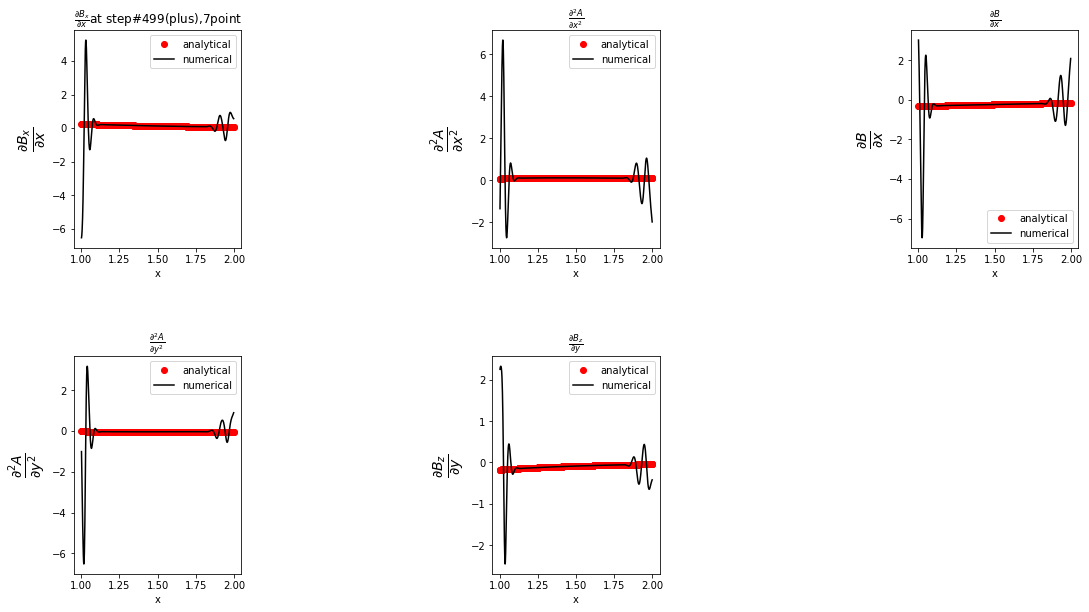

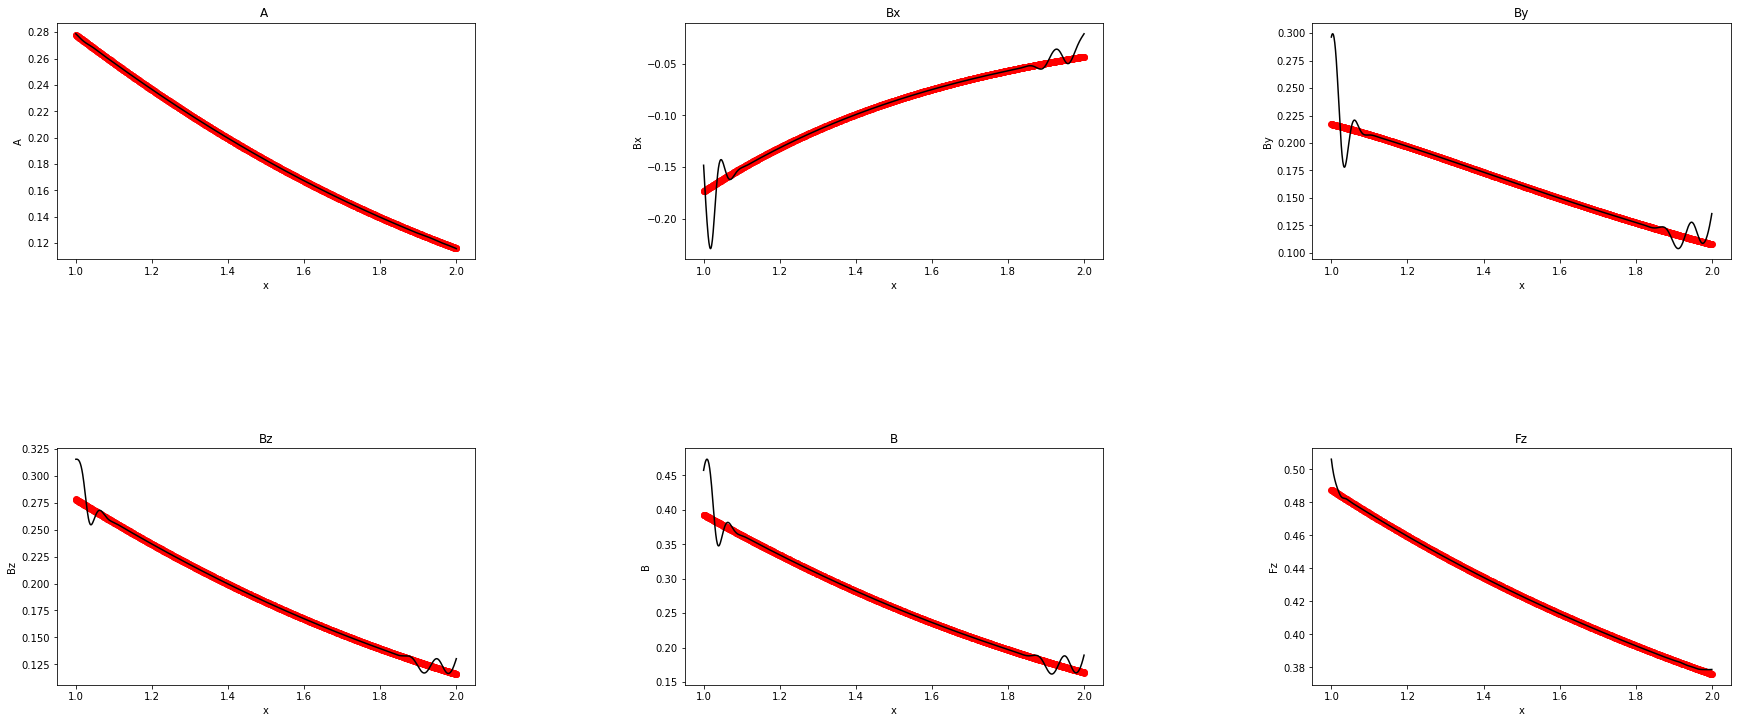

In [14]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ystep=499

ax1.plot(Xan[500,1:998],delBxdelxan[ycenter+ystep,1:998],'ro',label='analytical')
ax1.plot(Xan[500,1:998],delBxdelxrec_7point[ycenter+ystep,1:998],'k',label='numerical')
ax1.set_xlabel('x')
ax1.set_ylabel(r"$ \frac{\partial B_x}{\partial x} $",fontsize=20)
ax1.set_title(r"$ \frac{\partial B_x}{\partial x} $" 'at step#499(plus),7point')
ax1.legend()

ax2.plot(Xan[500,1:998],del2Adelx2an[ycenter+ystep,1:998],'ro',label='analytical')
ax2.plot(Xan[500,1:998],del2Adelx2rec_7point[ycenter+ystep,1:998],'k',label='numerical')
ax2.set_xlabel('x')
ax2.set_ylabel(r"$ \frac{\partial^2 A}{\partial x^2} $",fontsize=20)
ax2.set_title(r"$ \frac{\partial^2 A}{\partial x^2} $" )
ax2.legend()

ax3.plot(Xan[500,1:998],delBdelxan[ycenter+ystep,1:998],'ro',label='analytical')
ax3.plot(Xan[500,1:998],delBdelxrec_7point[ycenter+ystep,1:998],'k',label='numerical')
ax3.set_xlabel('x')
ax3.set_ylabel(r"$ \frac{\partial B}{\partial x} $",fontsize=20)
ax3.set_title(r"$ \frac{\partial B}{\partial x} $" )
ax3.legend()

ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

ax4.plot(Xan[500,1:998],del2Adely2an[ycenter+ystep,1:998],'ro',label='analytical')
ax4.plot(Xan[500,1:998],del2Adely2rec_7point[ycenter+ystep,1:998],'k',label='numerical')
ax4.set_xlabel('x')
ax4.set_ylabel(r"$ \frac{\partial^2 A}{\partial y^2} $",fontsize=20)
ax4.set_title(r"$ \frac{\partial^2 A}{\partial y^2} $" )
ax4.legend()

ax5.plot(Xan[500,1:998],delBzdelyan[ycenter+ystep,1:998],'ro',label='analytical')
ax5.plot(Xan[500,1:998],delBzdelyrec_7point[ycenter+ystep,1:998],'k',label='numerical')
ax5.set_xlabel('x')
ax5.set_ylabel(r"$ \frac{\partial B_z}{\partial y} $",fontsize=20)
ax5.set_title(r"$ \frac{\partial B_z}{\partial y} $" )
ax5.legend()

fig2 = plt.figure(figsize=(30,20))
ax1 = fig2.add_subplot(331)
ax2 = fig2.add_subplot(332)
ax3 = fig2.add_subplot(333)
ax4 = fig2.add_subplot(334)
ax5 = fig2.add_subplot(335)
ax6 = fig2.add_subplot(336)

ax1.plot(Xan[500,:],Aan[ycenter+ystep,:],'ro',label='analytical')
ax1.plot(Xan[500,:],Arec_7point[ycenter+ystep,:],'k',label='numerical')
ax1.set_xlabel('x')
ax1.set_ylabel('A')
ax1.set_title('A ')

ax2.plot(Xan[500,:],Bxan[ycenter+ystep,:],'ro',label='analytical')
ax2.plot(Xan[500,:],Bxrec_7point[ycenter+ystep,:],'k',label='numerical')
ax2.set_xlabel('x')
ax2.set_ylabel('Bx')
ax2.set_title('Bx')

ax3.plot(Xan[500,:],Byan[ycenter+ystep,:],'ro',label='analytical')
ax3.plot(Xan[500,:],Byrec_7point[ycenter+ystep,:],'k',label='numerical')
ax3.set_xlabel('x')
ax3.set_ylabel('By')
ax3.set_title('By')

ax4.plot(Xan[500,:],Bzan[ycenter+ystep,:],'ro',label='analytical')
ax4.plot(Xan[500,:],Bzrec_7point[ycenter+ystep,:],'k',label='numerical')
ax4.set_xlabel('x')
ax4.set_ylabel('Bz')
ax4.set_title('Bz')

ax5.plot(Xan[500,:],Ban[ycenter+ystep,:],'ro',label='analytical')
ax5.plot(Xan[500,:],Brec_7point[ycenter+ystep,:],'k',label='numerical')
ax5.set_xlabel('x')
ax5.set_ylabel('B')
ax5.set_title('B')

ax6.plot(Xan[500,:],Fzan[ycenter+ystep,:],'ro',label='analytical')
ax6.plot(Xan[500,:],Fzrec_7point[ycenter+ystep,:],'k',label='numerical')
ax6.set_xlabel('x')
ax6.set_ylabel('Fz')
ax6.set_title('Fz')

fig2.subplots_adjust(wspace=0.5,hspace=0.8)



fig.subplots_adjust(wspace=1.5,hspace=0.5)

In [15]:
err1 = np.empty((450))
err2 = np.empty((450))
err3 = np.empty((450))
err1_b = np.empty((450))
err2_b = np.empty((450))
err3_b = np.empty((450))
for i in range(450):
    err1[i] = np.sqrt(np.sum((Aan[ycenter:ycenter+i,:]-Arec[ycenter:ycenter+i,:])**2))
    err2[i] = np.sqrt(np.sum((Aan[ycenter:ycenter+i,:]-Arec_3point[ycenter:ycenter+i,:])**2))
    err3[i] = np.sqrt(np.sum((Aan[ycenter:ycenter+i,:]-Arec_7point[ycenter:ycenter+i,:])**2))

err1_b[:] = np.sqrt(np.sum((Aan[ycenter:ycenter+450,:]-Arec[ycenter:ycenter+450,:])**2,axis=1))
err2_b[:] = np.sqrt(np.sum((Aan[ycenter:ycenter+450,:]-Arec_3point[ycenter:ycenter+450,:])**2,axis=1))
err3_b[:] = np.sqrt(np.sum((Aan[ycenter:ycenter+450,:]-Arec_7point[ycenter:ycenter+450,:])**2,axis=1))

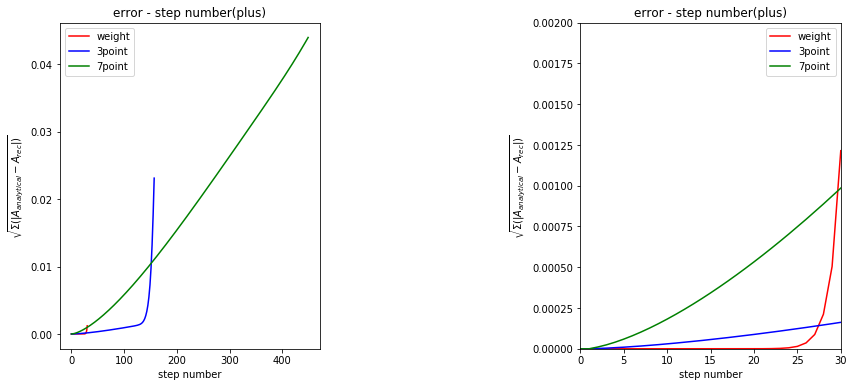

In [16]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
step = np.arange(0,450)
ax.plot(step,err1[:],'r',label='weight')
ax.plot(step,err2[:],'b',label='3point')
ax.plot(step,err3[:],'g',label='7point')
ax.set_xlabel('step number')
ax.set_ylabel(r"$\sqrt{\Sigma(|A_{analytical} - A_{rec}|)}$")
ax.set_title('error - step number(plus)')
ax.legend()
ax2 = fig.add_subplot(122)
ax2.plot(step,err1[:],'r',label='weight')
ax2.plot(step,err2[:],'b',label='3point')
ax2.plot(step,err3[:],'g',label='7point')
ax2.set_xlabel('step number')
ax2.set_ylabel(r"$\sqrt{\Sigma(|A_{analytical} - A_{rec}|)}$")
ax2.set_title('error - step number(plus)')
ax2.set_xlim(0,30)
ax2.set_ylim(0,0.002)
ax2.legend()

fig.subplots_adjust(wspace=1.0,hspace=0.5)

### とりあえず、正の方向に500ステップ分、発散せずに求められたので、今度は負の方向にやってみる
変えるのは、Apn,Bxpn,Bzpnを求める際の符号と、"rec"の配列に入れる際の符号

In [17]:
def reconstrction_minus_7point(Nx,Ny,Aobs,Bxobs,Byobs,Bzobs,alphapobs,Fzobs):
    Lx = Nx-1
    Ly = Ny-1
    Bobs = np.sqrt(Bxobs**2 + Byobs**2 + Bzobs**2)

    #パラメータ設定-
    delBxdelxtmp = np.zeros((Nx))
    del2Adelx2tmp = np.zeros((Nx))
    delBdelxtmp = np.zeros((Nx))
    Apn = np.zeros((Nx))
    Bxpn = np.zeros((Nx))
    Bzpn = np.zeros((Nx))
    Bypn = np.zeros((Nx))
    
    Arec = np.empty((Ny,Nx))
    Bxrec = np.empty((Ny,Nx))
    Byrec = np.empty((Ny,Nx))
    Bzrec = np.empty((Ny,Nx))
    Brec = np.empty((Ny,Nx))
    alpharec = np.empty((Ny,Nx))
    Fzrec = np.empty((Ny,Nx))
    delBxdelxrec = np.empty((Ny,Nx))
    del2Adelx2rec = np.empty((Ny,Nx))
    delBdelxrec = np.empty((Ny,Nx))
    del2Adely2rec = np.empty((Ny,Nx))
    delBzdelyrec = np.empty((Ny,Nx))
    
    Arec[ycenter,:] = Aobs
    Bxrec[ycenter,:] = Bxobs
    Byrec[ycenter,:] = Byobs
    Bzrec[ycenter,:] = Bzobs
    Brec[ycenter,:] = Bobs
    alpharec[ycenter,:] = alphaobs
    Fzrec[ycenter,:] = Fzobs
    
    Mtmp = np.empty((Nx,2,2))
    Mtmpinv11 = np.empty((Nx))
    Mtmpinv12 = np.empty((Nx))
    Mtmpinv21 = np.empty((Nx))
    Mtmpinv22 = np.empty((Nx))
    
    i = np.arange(1,Lx)#x方向のグリッドの端0とLxを除いた分の配列 1~Lx-1
    i7 = np.arange(3,Lx-2)#3~Lx-3,スムージングの際に使う
    
    Aprev = Aobs
    Bxprev = Bxobs
    Byprev = Byobs
    Bzprev = Bzobs
    Bprev = Bobs
    alphaprev = alphaobs
    Fzprev = Fzobs
    dFzdAprev = dFzdAanf(Aobs)
    dalphadBprev = dalphadBanf(Bobs)
    
    
    for j in range(1,ycenter+1):#j = 1~ycenter,stepnumber
        #x-difference
        delBxdelxtmp[i] = (Bxprev[i+1] - Bxprev[i-1])/(2*deltax)
        del2Adelx2tmp[i] = (Aprev[i+1] - 2*Aprev[i] + Aprev[i-1])/(deltax**2)
        delBdelxtmp[i] = (Bprev[i+1] - Bprev[i-1])/(2*deltax)
        
        delBxdelxtmp[0] = (1/6)*(-11*Bxprev[0] + 18*Bxprev[1] - 9*Bxprev[2] + 2*Bxprev[3])/deltax
        delBxdelxtmp[Lx] = (1/6)*(11*Bxprev[Lx] - 18*Bxprev[Lx-1] + 9*Bxprev[Lx-2] - 2*Bxprev[Lx-3])/deltax
        del2Adelx2tmp[0] = (2*Aprev[0] - 5*Aprev[1] + 4*Aprev[2] - Aprev[3])/(deltax**2)
        del2Adelx2tmp[Lx] = (2*Aprev[Lx] - 5*Aprev[Lx-1] + 4*Aprev[Lx-2] - Aprev[Lx-3])/(deltax**2)
        delBdelxtmp[0] = (1/6)*(-11*Bprev[0] + 18*Bprev[1] - 9*Bprev[2] + 2*Bprev[3])/deltax
        delBdelxtmp[Lx] = (1/6)*(11*Bprev[Lx] - 18*Bprev[Lx-1] + 9*Bprev[Lx-2] - 2*Bprev[Lx-3])/deltax 
        
        
        #Matrix
        Y1tmp = -(1-alphaprev)*del2Adelx2tmp - Byprev*dalphadBprev*delBdelxtmp - (Bxprev*Byprev/Bprev)*dalphadBprev*delBxdelxtmp - Bzprev*dFzdAprev
        Y2tmp = -(Byprev*Bzprev/Bprev)*dalphadBprev*delBxdelxtmp + Bxprev*dFzdAprev
        M11tmp = (1-alphaprev) - ((Bxprev**2)/Bprev)*dalphadBprev
        M12tmp = -(Bxprev*Bzprev/Bprev)*dalphadBprev
        M22tmp = (1-alphaprev) - ((Bzprev**2)/Bprev)*dalphadBprev
        
        Mtmp[:,0,0] = M11tmp[:]
        Mtmp[:,0,1] = M12tmp[:]
        Mtmp[:,1,0] = M12tmp[:]
        Mtmp[:,1,1] = M22tmp[:]
        
        Mtmpinv = np.linalg.inv(Mtmp)
        
        Mtmpinv11[:] = Mtmpinv[:,0,0]
        Mtmpinv12[:] = Mtmpinv[:,0,1]
        Mtmpinv21[:] = Mtmpinv[:,1,0]
        Mtmpinv22[:] = Mtmpinv[:,1,1]
        
        #y-difference
        del2Adely2tmp = Mtmpinv11*Y1tmp + Mtmpinv12*Y2tmp
        delBzdelytmp = Mtmpinv21*Y1tmp + Mtmpinv22*Y2tmp
        
        
        Apn  = Aprev - deltay*Bxprev + 0.5*(deltay**2)*del2Adely2tmp
        Bxpn = Bxprev - deltay*del2Adely2tmp
        Bzpn = Bzprev - deltay*delBzdelytmp
        
        #boundary conditionで0と999を補う
        Apn[0] = 4*Apn[1] - 6*Apn[2] + 4*Apn[3] - Apn[4]
        Apn[Lx] = 4*Apn[Lx-1] - 6*Apn[Lx-2] + 4*Apn[Lx-3] - Apn[Lx-4]
        Bxpn[0] = 4*Bxpn[1] - 6*Bxpn[2] + 4*Bxpn[3] - Bxpn[4]
        Bxpn[Lx] = 4*Bxpn[Lx-1] - 6*Bxpn[Lx-2] + 4*Bxpn[Lx-3] - Bxpn[Lx-4]
        Bzpn[0] = 4*Bzpn[1] - 6*Bzpn[2] + 4*Bzpn[3] - Bzpn[4]
        Bzpn[Lx] = 4*Bzpn[Lx-1] - 6*Bzpn[Lx-2] + 4*Bzpn[Lx-3] - Bzpn[Lx-4]   
        
        #smoothing
        Apn[i7] = (1/7)*(Apn[i7-3] + Apn[i7-2] + Apn[i7-1] + Apn[i7] + Apn[i7+1] + Apn[i7+2] + Apn[i7+3])
        Bxpn[i7] = (1/7)*(Bxpn[i7-3] + Bxpn[i7-2] + Bxpn[i7-1] + Bxpn[i7] + Bxpn[i7+1] + Bxpn[i7+2] + Bxpn[i7+3])
        Bzpn[i7] = (1/7)*(Bzpn[i7-3] + Bzpn[i7-2] + Bzpn[i7-1] + Bzpn[i7] + Bzpn[i7+1] + Bzpn[i7+2] + Bzpn[i7+3])
        
        #boundary condition
        Apn[2] = 4*Apn[3] - 6*Apn[4] + 4*Apn[5] - Apn[6]
        Apn[Lx-2] = 4*Apn[Lx-3] - 6*Apn[Lx-4] + 4*Apn[Lx-5] - Apn[Lx-6]
        Apn[1] = 4*Apn[2] - 6*Apn[3] + 4*Apn[4] - Apn[5]
        Apn[Lx-1] = 4*Apn[Lx-2] - 6*Apn[Lx-3] + 4*Apn[Lx-4] - Apn[Lx-5]
        Apn[0] = 4*Apn[1] - 6*Apn[2] + 4*Apn[3] - Apn[4]
        Apn[Lx] = 4*Apn[Lx-1] - 6*Apn[Lx-2] + 4*Apn[Lx-3] - Apn[Lx-4]
        Bxpn[2] = 4*Bxpn[3] - 6*Bxpn[4] + 4*Bxpn[5] - Bxpn[6]
        Bxpn[Lx-2] = 4*Bxpn[Lx-3] - 6*Bxpn[Lx-4] + 4*Bxpn[Lx-5] - Bxpn[Lx-6]
        Bxpn[1] = 4*Bxpn[2] - 6*Bxpn[3] + 4*Bxpn[4] - Bxpn[5]
        Bxpn[Lx-1] = 4*Bxpn[Lx-2] - 6*Bxpn[Lx-3] + 4*Bxpn[Lx-4] - Bxpn[Lx-5]
        Bxpn[0] = 4*Bxpn[1] - 6*Bxpn[2] + 4*Bxpn[3] - Bxpn[4]
        Bxpn[Lx] = 4*Bxpn[Lx-1] - 6*Bxpn[Lx-2] + 4*Bxpn[Lx-3] - Bxpn[Lx-4]
        Bzpn[2] = 4*Bzpn[3] - 6*Bzpn[4] + 4*Bzpn[5] - Bzpn[6]
        Bzpn[Lx-2] = 4*Bzpn[Lx-3] - 6*Bzpn[Lx-4] + 4*Bzpn[Lx-5] - Bzpn[Lx-6]
        Bzpn[1] = 4*Bzpn[2] - 6*Bzpn[3] + 4*Bzpn[4] - Bzpn[5]
        Bzpn[Lx-1] = 4*Bzpn[Lx-2] - 6*Bzpn[Lx-3] + 4*Bzpn[Lx-4] - Bzpn[Lx-5] 
        Bzpn[0] = 4*Bzpn[1] - 6*Bzpn[2] + 4*Bzpn[3] - Bzpn[4]
        Bzpn[Lx] = 4*Bzpn[Lx-1] - 6*Bzpn[Lx-2] + 4*Bzpn[Lx-3] - Bzpn[Lx-4]  
        
        #By
        Bypn[i] = -(Apn[i+1] -Apn[i-1])/(2*deltax)
        Bypn[0] = -(1/6)*(-11*Apn[0] + 18*Apn[1] - 9*Apn[2] + 2*Apn[3])/deltax
        Bypn[Lx] = -(1/6)*(11*Apn[Lx] - 18*Apn[Lx-1] + 9*Apn[Lx-2] - 2*Apn[Lx-3])/deltax
        #Smoothing
        Bypn[i7] = (1/7)*(Bypn[i7-3] + Bypn[i7-2] + Bypn[i7-1] + Bypn[i7] + Bypn[i7+1] + Bypn[i7+2] + Bypn[i7+3])
        #boundary condition
        Bypn[2] = 4*Bypn[3] - 6*Bypn[4] + 4*Bypn[5] - Bypn[6]
        Bypn[Lx-2] = 4*Bypn[Lx-3] - 6*Bypn[Lx-4] + 4*Bypn[Lx-5] - Bypn[Lx-6]
        Bypn[1] = 4*Bypn[2] - 6*Bypn[3] + 4*Bypn[4] - Bypn[5]
        Bypn[Lx-1] = 4*Bypn[Lx-2] - 6*Bypn[Lx-3] + 4*Bypn[Lx-4] - Bypn[Lx-5]
        Bypn[0] = 4*Bypn[1] - 6*Bypn[2] + 4*Bypn[3] - Bypn[4]
        Bypn[Lx] = 4*Bypn[Lx-1] - 6*Bypn[Lx-2] + 4*Bypn[Lx-3] - Bypn[Lx-4]
        
        Bpn = np.sqrt(Bxpn**2 + Bypn**2 + Bzpn**2)
        alphapn = alphaanf(Bpn)
        Fzpn = (1 - alphapn)*Bzpn
        
        
        Arec[ycenter-j,:] = Apn[:]
        Bxrec[ycenter-j,:] = Bxpn[:]
        Byrec[ycenter-j,:] = Bypn[:]
        Bzrec[ycenter-j,:] = Bzpn[:]
        Brec[ycenter-j,:]  = Bpn[:]
        alpharec[ycenter-j,:] = alphapn[:]
        Fzrec[ycenter-j,:] = Fzpn[:]
        #各方向への差分で求めた微分の値は、その場での値
        delBxdelxrec[ycenter-j+1,:] = delBxdelxtmp[:] 
        del2Adelx2rec[ycenter-j+1,:] = del2Adelx2tmp[:]
        delBdelxrec[ycenter-j+1,:] = delBdelxtmp[:]
        del2Adely2rec[ycenter-j+1,:] = del2Adely2tmp[:] 
        delBzdelyrec[ycenter-j+1,:] = delBzdelytmp[:] 
        
        Aprev = Apn
        Bxprev = Bxpn
        Byprev = Bypn
        Bzprev = Bzpn
        Bprev = Bpn
        alphaprev = alphapn
        Fzprev = Fzpn
        dFzdAprev = dFzdAanf(Apn)
        dalphadBprev = dalphadBanf(Bpn)
#繰り返しここまで-------------------------------------------------------------------    

    return Arec,Bxrec,Byrec,Bzrec,Brec,alpharec,Fzrec,delBxdelxrec,del2Adelx2rec,delBdelxrec,del2Adely2rec,delBzdelyrec


In [18]:
conc3_minus = reconstrction_minus_7point(nx,ny,Aobs,Bxobs,Byobs,Bzobs,alphaobs,Fzobs)

for k in range (1,501):#1~500
                Arec_7point[ycenter-k,:] = conc3_minus[0][ycenter-k,:]
                Bxrec_7point[ycenter-k,:] = conc3_minus[1][ycenter-k,:]
                Byrec_7point[ycenter-k,:] = conc3_minus[2][ycenter-k,:]
                Bzrec_7point[ycenter-k,:] = conc3_minus[3][ycenter-k,:]
                Brec_7point[ycenter-k,:] = conc3_minus[4][ycenter-k,:]
                alpharec_7point[ycenter-k,:] = conc3_minus[5][ycenter-k,:]
                Fzrec_7point[ycenter-k,:] = conc3_minus[6][ycenter-k,:]
                delBxdelxrec_7point[ycenter-k,:] = conc3_minus[7][ycenter-k,:]
                del2Adelx2rec_7point[ycenter-k,:] = conc3_minus[8][ycenter-k,:]
                delBdelxrec_7point[ycenter-k,:] = conc3_minus[9][ycenter-k,:]
                del2Adely2rec_7point[ycenter-k,:] = conc3_minus[10][ycenter-k,:]
                delBzdelyrec_7point[ycenter-k,:] = conc3_minus[11][ycenter-k,:]
                

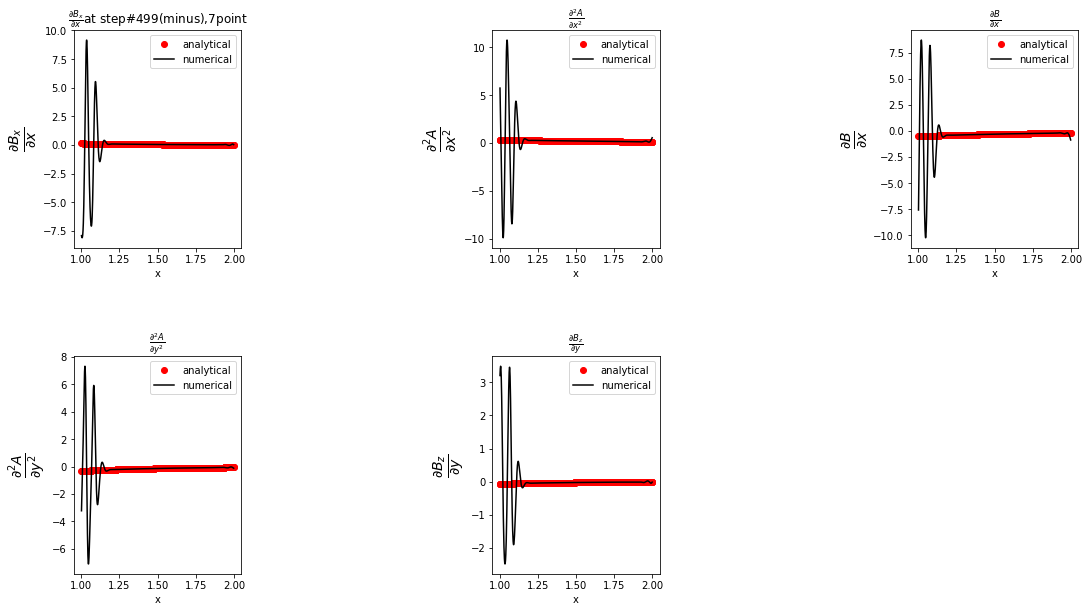

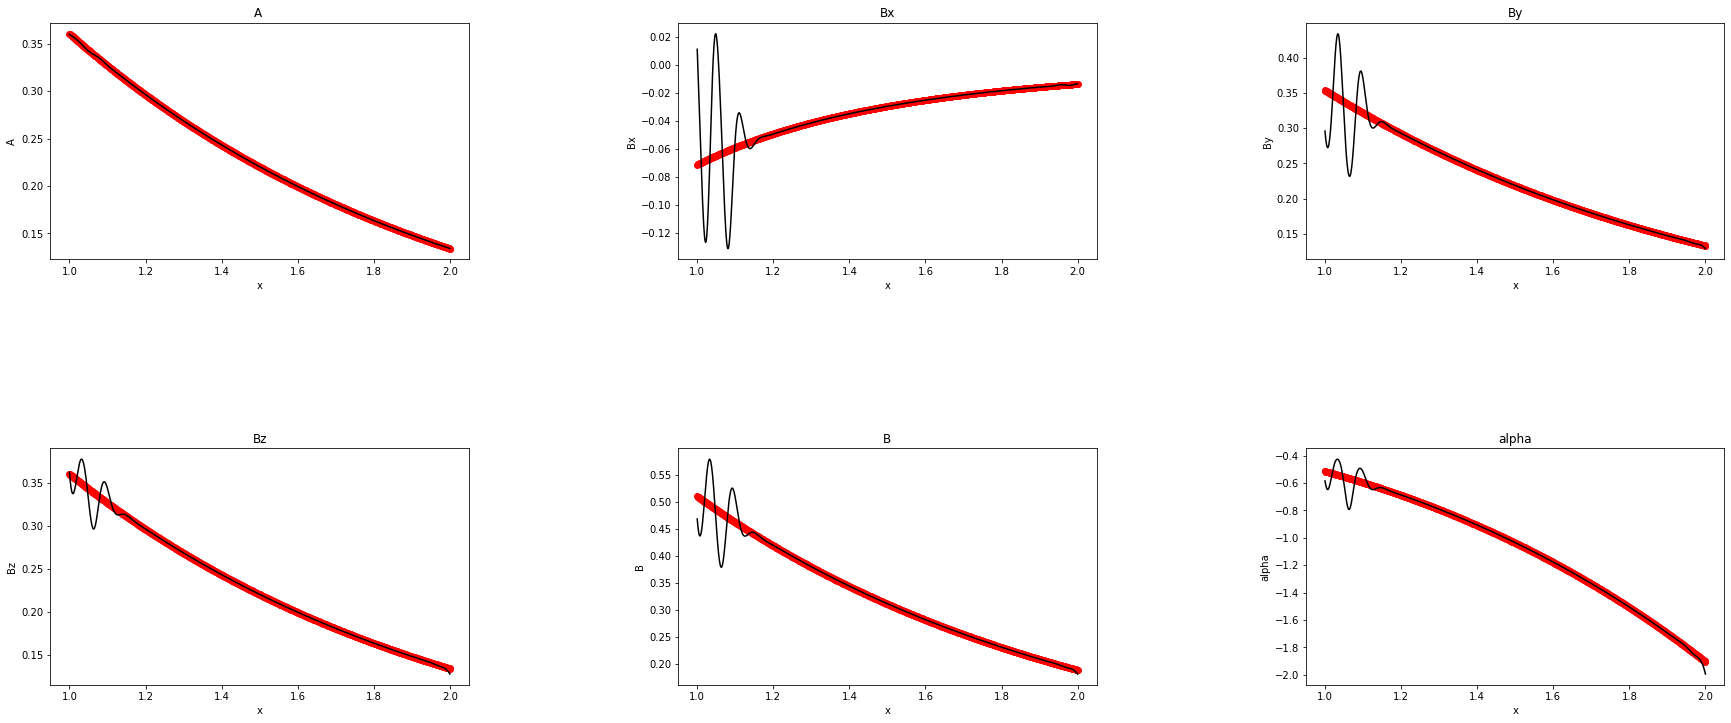

In [19]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ystep=499

ax1.plot(Xan[500,1:998],delBxdelxan[ycenter-ystep,1:998],'ro',label='analytical')
ax1.plot(Xan[500,1:998],delBxdelxrec_7point[ycenter-ystep,1:998],'k',label='numerical')
ax1.set_xlabel('x')
ax1.set_ylabel(r"$ \frac{\partial B_x}{\partial x} $",fontsize=20)
ax1.set_title(r"$ \frac{\partial B_x}{\partial x} $" 'at step#499(minus),7point')
ax1.legend()

ax2.plot(Xan[500,1:998],del2Adelx2an[ycenter-ystep,1:998],'ro',label='analytical')
ax2.plot(Xan[500,1:998],del2Adelx2rec_7point[ycenter-ystep,1:998],'k',label='numerical')
ax2.set_xlabel('x')
ax2.set_ylabel(r"$ \frac{\partial^2 A}{\partial x^2} $",fontsize=20)
ax2.set_title(r"$ \frac{\partial^2 A}{\partial x^2} $" )
ax2.legend()

ax3.plot(Xan[500,1:998],delBdelxan[ycenter-ystep,1:998],'ro',label='analytical')
ax3.plot(Xan[500,1:998],delBdelxrec_7point[ycenter-ystep,1:998],'k',label='numerical')
ax3.set_xlabel('x')
ax3.set_ylabel(r"$ \frac{\partial B}{\partial x} $",fontsize=20)
ax3.set_title(r"$ \frac{\partial B}{\partial x} $" )
ax3.legend()

ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

ax4.plot(Xan[500,1:998],del2Adely2an[ycenter-ystep,1:998],'ro',label='analytical')
ax4.plot(Xan[500,1:998],del2Adely2rec_7point[ycenter-ystep,1:998],'k',label='numerical')
ax4.set_xlabel('x')
ax4.set_ylabel(r"$ \frac{\partial^2 A}{\partial y^2} $",fontsize=20)
ax4.set_title(r"$ \frac{\partial^2 A}{\partial y^2} $" )
ax4.legend()

ax5.plot(Xan[500,1:998],delBzdelyan[ycenter-ystep,1:998],'ro',label='analytical')
ax5.plot(Xan[500,1:998],delBzdelyrec_7point[ycenter-ystep,1:998],'k',label='numerical')
ax5.set_xlabel('x')
ax5.set_ylabel(r"$ \frac{\partial B_z}{\partial y} $",fontsize=20)
ax5.set_title(r"$ \frac{\partial B_z}{\partial y} $" )
ax5.legend()

fig2 = plt.figure(figsize=(30,20))
ax1 = fig2.add_subplot(331)
ax2 = fig2.add_subplot(332)
ax3 = fig2.add_subplot(333)
ax4 = fig2.add_subplot(334)
ax5 = fig2.add_subplot(335)
ax6 = fig2.add_subplot(336)

ax1.plot(Xan[500,:],Aan[ycenter-ystep,:],'ro',label='analytical')
ax1.plot(Xan[500,:],Arec_7point[ycenter-ystep,:],'k',label='numerical')
ax1.set_xlabel('x')
ax1.set_ylabel('A')
ax1.set_title('A ')

ax2.plot(Xan[500,:],Bxan[ycenter-ystep,:],'ro',label='analytical')
ax2.plot(Xan[500,:],Bxrec_7point[ycenter-ystep,:],'k',label='numerical')
ax2.set_xlabel('x')
ax2.set_ylabel('Bx')
ax2.set_title('Bx')

ax3.plot(Xan[500,:],Byan[ycenter-ystep,:],'ro',label='analytical')
ax3.plot(Xan[500,:],Byrec_7point[ycenter-ystep,:],'k',label='numerical')
ax3.set_xlabel('x')
ax3.set_ylabel('By')
ax3.set_title('By')

ax4.plot(Xan[500,:],Bzan[ycenter-ystep,:],'ro',label='analytical')
ax4.plot(Xan[500,:],Bzrec_7point[ycenter-ystep,:],'k',label='numerical')
ax4.set_xlabel('x')
ax4.set_ylabel('Bz')
ax4.set_title('Bz')

ax5.plot(Xan[500,:],Ban[ycenter-ystep,:],'ro',label='analytical')
ax5.plot(Xan[500,:],Brec_7point[ycenter-ystep,:],'k',label='numerical')
ax5.set_xlabel('x')
ax5.set_ylabel('B')
ax5.set_title('B')

ax6.plot(Xan[500,:],alphaan[ycenter-ystep,:],'ro',label='analytical')
ax6.plot(Xan[500,:],alpharec_7point[ycenter-ystep,:],'k',label='numerical')
ax6.set_xlabel('x')
ax6.set_ylabel('alpha')
ax6.set_title('alpha')

fig2.subplots_adjust(wspace=0.5,hspace=0.8)



fig.subplots_adjust(wspace=1.5,hspace=0.5)

### この上の図は、マイナス方向にreconstructionした結果、つまりy~0.5から始めてy~0.2あたりの結果ということである
逆に、プラス方向にした結果はy=0.8付近の結果になっている

## 下に、Aとαを解析解と比較した図を載せる

In [20]:
xtraj = Xan[500,:]
ytraj = np.empty((nx))
ytraj[:] = 0.5

C:\Users\Ryoya Shimada\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  from ipykernel import kernelapp as app


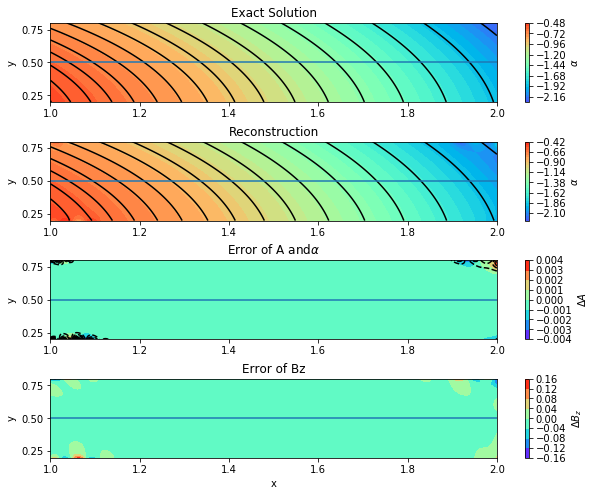

In [21]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(411)
ax.contour(Xan,Yan,Aan,levels=20,colors='k')
alphacontour = ax.contourf(Xan,Yan,alphaan,levels=30,cmap='rainbow',norm=Normalize(vmin=-2.5,vmax=-0.3))
cbar = fig.colorbar(alphacontour)
cbar.ax.set_ylabel(r"$\alpha$")
ax.plot(xtraj,ytraj)
ax.set_ylabel('y')
ax.set_title('Exact Solution')

ax2 = fig.add_subplot(412)
ax2.contour(Xan,Yan,Arec_7point,levels=20,colors='k')
alphacontour2 = ax2.contourf(Xan,Yan,alpharec_7point,levels=30,cmap='rainbow',norm=Normalize(vmin=-2.5,vmax=-0.3))
cbar2 = fig.colorbar(alphacontour2)
cbar2.set_clim(-2.5,-0.3)
cbar2.ax.set_ylabel(r"$\alpha$")
ax2.plot(xtraj,ytraj)
ax2.set_ylabel('y')
ax2.set_title('Reconstruction')

errA = (Aan - Arec_7point)/Aan
erralpha = np.abs((alphaan - alpharec_7point))/alphaan
ax3 = fig.add_subplot(413)
ax3.plot(xtraj,ytraj)
e = ax3.contour(Xan,Yan,erralpha,levels=10,colors='k')
e.clabel()
eA = ax3.contourf(Xan,Yan,errA,cmap='rainbow')
cbar3 = fig.colorbar(eA)
cbar3.ax.set_ylabel(r"$\Delta A$")
#ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('Error of A and' r"$\alpha$")

errBz = (Bzan - Bzrec_7point)/Bzan
ax4 = fig.add_subplot(414)
ax4.plot(xtraj,ytraj)
eBz = ax4.contourf(Xan,Yan,errBz,cmap='rainbow')
cbar = fig.colorbar(eBz)
cbar.ax.set_ylabel(r"$\Delta B_z$")
fig.subplots_adjust(wspace=1.5,hspace=0.5)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title('Error of Bz')

plt.show()


## deltayを半分にして、その分グリッド数を倍にしてやってみる

In [22]:
nx = 1000
ny = 2001
ycenter = int((ny-1)/2)
deltay = 0.6/(ny-1)
deltax = 1.0/nx

xan = np.linspace(1,2,nx)
yan = np.linspace(0.2,0.8,ny)
Xan,Yan = np.meshgrid(xan,yan)
Ran = np.sqrt(Xan**2 + Yan**2)
    
Aan = np.exp(-Ran)
Bxan = -(Yan/Ran)*np.exp(-Ran)
Byan =  (Xan/Ran)*np.exp(-Ran)
Bzan = np.exp(-Ran)
Ban = np.sqrt(2)*np.exp(-Ran)#実際にはBx,By,Bzから求める
Fzan = np.exp(-1+np.log(1.5))*np.exp(-0.5*np.log(Ran))#実際にはalphaとBzから求める 
alphaan = 1.0 - np.exp(-(1.0 + 0.5*np.log(Ran) - Ran - np.log(1.5)))
    
#x方向への微分の解析解
delBxdelxan = (Xan*Yan*(Ran+1)*np.exp(-Ran))/(Ran**3)
del2Adelx2an = (np.exp(-Ran)/Ran)*((Xan**2/(Ran**2))*(Ran+1) - 1)
delBdelxan = -np.sqrt(2)*Xan*np.exp(-Ran)/Ran
    
#y方向への微分の解析解
del2Adely2an = (np.exp(-Ran)/Ran)*((Yan**2/(Ran**2))*(Ran+1) - 1)
delBzdelyan = -(Yan/Ran)*np.exp(-Ran)
#----------------------------------------------------------------------------------------------------

Aobs = Aan[ycenter,:]
Bxobs = Bxan[ycenter,:]
Byobs = Byan[ycenter,:]
Bzobs = Bzan[ycenter,:]
Bobs = Ban[ycenter,:]
alphaobs = alphaan[ycenter,:]
Fzobs = Fzan[ycenter,:]
dFzdAobs = dFzdAanf(Aan[ycenter,:])
dalphadBobs = dalphadBanf(Ban[ycenter,:])


conc4 = reconstrction_3point(nx,ny,Aobs,Bxobs,Byobs,Bzobs,alphaobs,Fzobs)

Arec_3point_2001 = conc4[0]
Bxrec_3point_2001 = conc4[1]
Byrec_3point_2001 = conc4[2]
Bzrec_3point_2001 = conc4[3]
Brec_3point_2001 = conc4[4]
alpharec_3point_2001 = conc4[5]
Fzrec_3point_2001 = conc4[6]
delBxdelxrec_3point_2001 = conc4[7]
del2Adelx2rec_3point_2001 = conc4[8]
delBdelxrec_3point_2001 = conc4[9]
del2Adely2rec_3point_2001 = conc4[10]
delBzdelyrec_3point_2001 = conc4[11]


C:\Users\Ryoya Shimada\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
C:\Users\Ryoya Shimada\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log


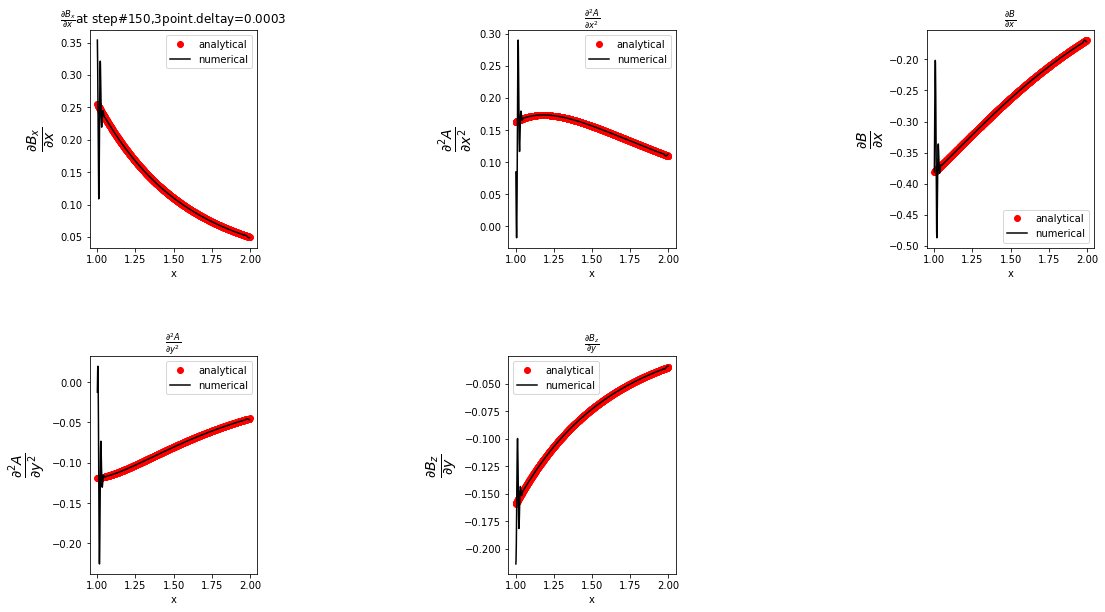

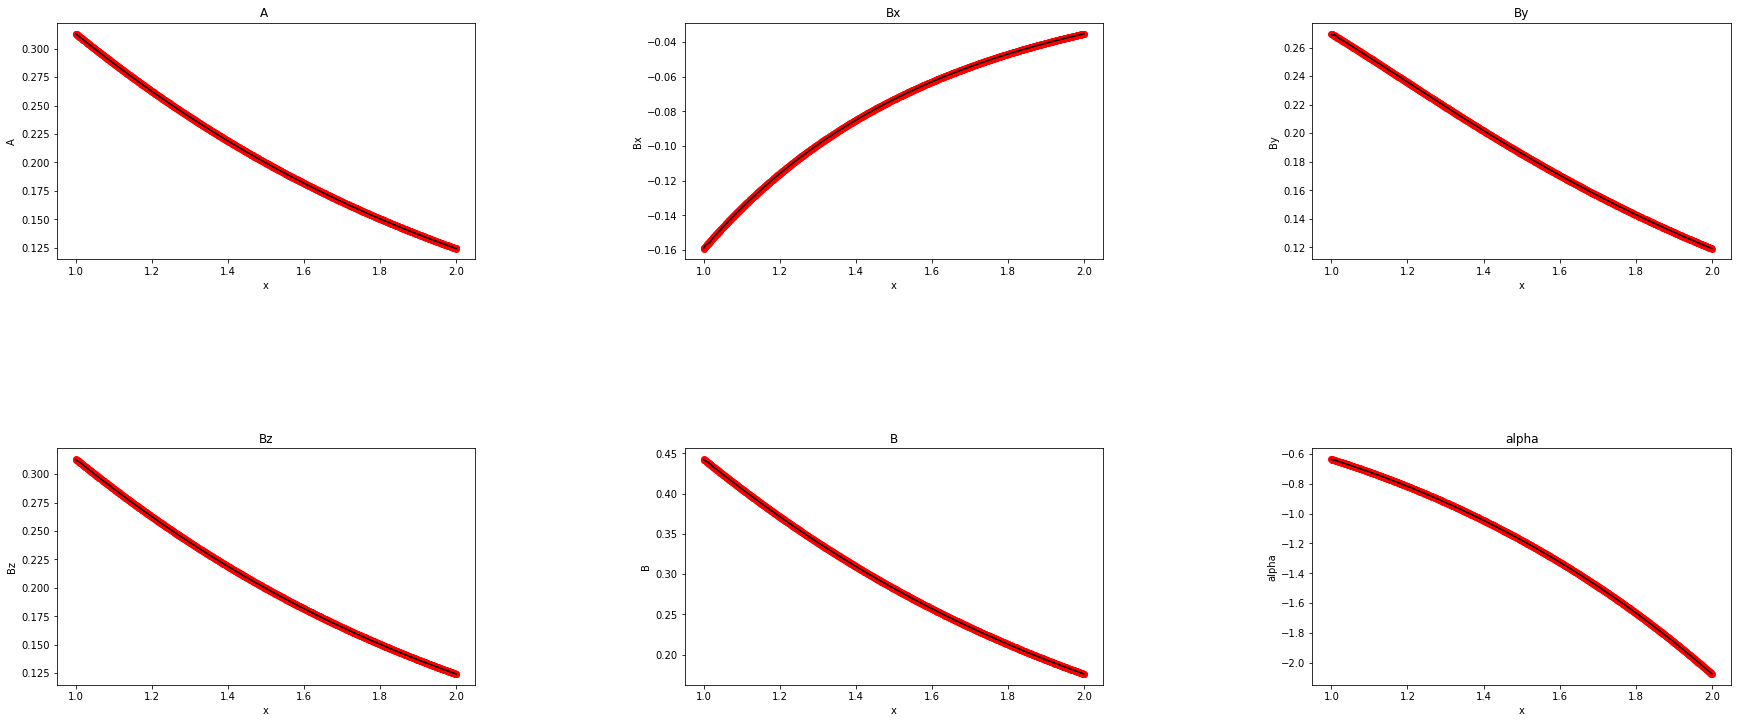

In [23]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ystep=300

ax1.plot(Xan[500,1:998],delBxdelxan[ycenter+ystep,1:998],'ro',label='analytical')
ax1.plot(Xan[500,1:998],delBxdelxrec_3point_2001[ycenter+ystep,1:998],'k',label='numerical')
ax1.set_xlabel('x')
ax1.set_ylabel(r"$ \frac{\partial B_x}{\partial x} $",fontsize=20)
ax1.set_title(r"$ \frac{\partial B_x}{\partial x} $" 'at step#150,3point.deltay=0.0003')
ax1.legend()

ax2.plot(Xan[500,1:998],del2Adelx2an[ycenter+ystep,1:998],'ro',label='analytical')
ax2.plot(Xan[500,1:998],del2Adelx2rec_3point_2001[ycenter+ystep,1:998],'k',label='numerical')
ax2.set_xlabel('x')
ax2.set_ylabel(r"$ \frac{\partial^2 A}{\partial x^2} $",fontsize=20)
ax2.set_title(r"$ \frac{\partial^2 A}{\partial x^2} $" )
ax2.legend()

ax3.plot(Xan[500,1:998],delBdelxan[ycenter+ystep,1:998],'ro',label='analytical')
ax3.plot(Xan[500,1:998],delBdelxrec_3point_2001[ycenter+ystep,1:998],'k',label='numerical')
ax3.set_xlabel('x')
ax3.set_ylabel(r"$ \frac{\partial B}{\partial x} $",fontsize=20)
ax3.set_title(r"$ \frac{\partial B}{\partial x} $" )
ax3.legend()

ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

ax4.plot(Xan[500,1:998],del2Adely2an[ycenter+ystep,1:998],'ro',label='analytical')
ax4.plot(Xan[500,1:998],del2Adely2rec_3point_2001[ycenter+ystep,1:998],'k',label='numerical')
ax4.set_xlabel('x')
ax4.set_ylabel(r"$ \frac{\partial^2 A}{\partial y^2} $",fontsize=20)
ax4.set_title(r"$ \frac{\partial^2 A}{\partial y^2} $" )
ax4.legend()

ax5.plot(Xan[500,1:998],delBzdelyan[ycenter+ystep,1:998],'ro',label='analytical')
ax5.plot(Xan[500,1:998],delBzdelyrec_3point_2001[ycenter+ystep,1:998],'k',label='numerical')
ax5.set_xlabel('x')
ax5.set_ylabel(r"$ \frac{\partial B_z}{\partial y} $",fontsize=20)
ax5.set_title(r"$ \frac{\partial B_z}{\partial y} $" )
ax5.legend()

fig2 = plt.figure(figsize=(30,20))
ax1 = fig2.add_subplot(331)
ax2 = fig2.add_subplot(332)
ax3 = fig2.add_subplot(333)
ax4 = fig2.add_subplot(334)
ax5 = fig2.add_subplot(335)
ax6 = fig2.add_subplot(336)

ax1.plot(Xan[500,:],Aan[ycenter+ystep,:],'ro',label='analytical')
ax1.plot(Xan[500,:],Arec_3point_2001[ycenter+ystep,:],'k',label='numerical')
ax1.set_xlabel('x')
ax1.set_ylabel('A')
ax1.set_title('A ')

ax2.plot(Xan[500,:],Bxan[ycenter+ystep,:],'ro',label='analytical')
ax2.plot(Xan[500,:],Bxrec_3point_2001[ycenter+ystep,:],'k',label='numerical')
ax2.set_xlabel('x')
ax2.set_ylabel('Bx')
ax2.set_title('Bx')

ax3.plot(Xan[500,:],Byan[ycenter+ystep,:],'ro',label='analytical')
ax3.plot(Xan[500,:],Byrec_3point_2001[ycenter+ystep,:],'k',label='numerical')
ax3.set_xlabel('x')
ax3.set_ylabel('By')
ax3.set_title('By')

ax4.plot(Xan[500,:],Bzan[ycenter+ystep,:],'ro',label='analytical')
ax4.plot(Xan[500,:],Bzrec_3point_2001[ycenter+ystep,:],'k',label='numerical')
ax4.set_xlabel('x')
ax4.set_ylabel('Bz')
ax4.set_title('Bz')

ax5.plot(Xan[500,:],Ban[ycenter+ystep,:],'ro',label='analytical')
ax5.plot(Xan[500,:],Brec_3point_2001[ycenter+ystep,:],'k',label='numerical')
ax5.set_xlabel('x')
ax5.set_ylabel('B')
ax5.set_title('B')

ax6.plot(Xan[500,:],alphaan[ycenter+ystep,:],'ro',label='analytical')
ax6.plot(Xan[500,:],alpharec_3point_2001[ycenter+ystep,:],'k',label='numerical')
ax6.set_xlabel('x')
ax6.set_ylabel('alpha')
ax6.set_title('alpha')

fig2.subplots_adjust(wspace=0.5,hspace=0.8)



fig.subplots_adjust(wspace=1.5,hspace=0.5)

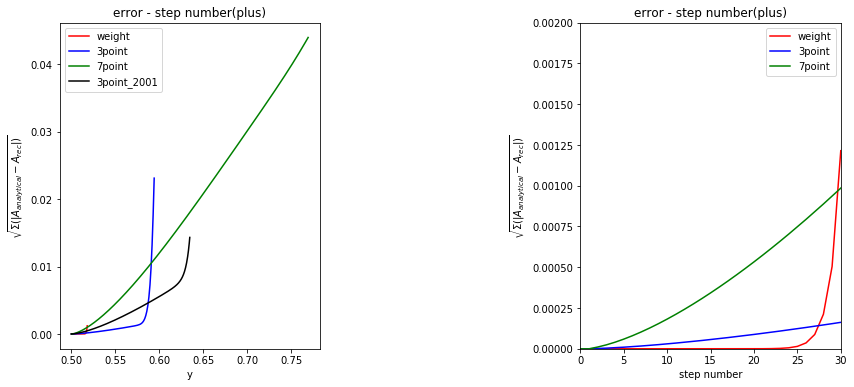

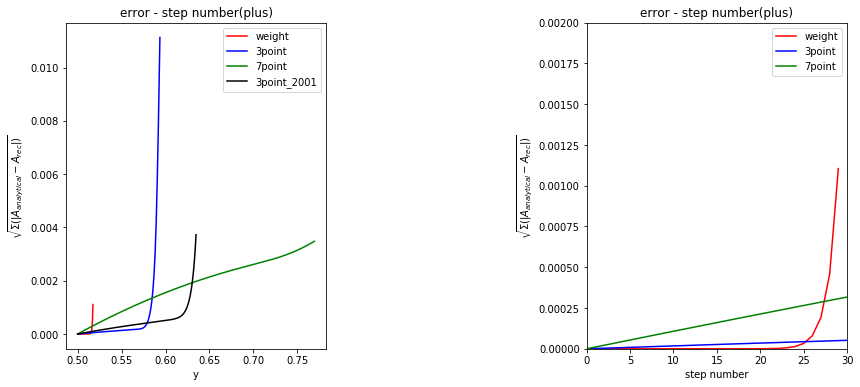

In [24]:
err4 = np.empty((450))
err4_b = np.empty((450))
for i in range(450):
    err4[i] = np.sqrt(np.sum((Aan[ycenter:ycenter+i,:]-Arec_3point_2001[ycenter:ycenter+i,:])**2))

err4_b[:] = np.sqrt(np.sum((Aan[ycenter:ycenter+450,:]-Arec_3point_2001[ycenter:ycenter+450,:])**2,axis=1))
    
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
step = np.arange(0,450)
ax.plot(0.5+step*deltay*2,err1[:],'r',label='weight')
ax.plot(0.5+step*deltay*2,err2[:],'b',label='3point')
ax.plot(0.5+step*deltay*2,err3[:],'g',label='7point')
ax.plot(0.5+step*deltay,err4[:],'k',label='3point_2001')
ax.set_xlabel('y')
ax.set_ylabel(r"$\sqrt{\Sigma(|A_{analytical} - A_{rec}|)}$")
ax.set_title('error - step number(plus)')
ax.legend()
ax2 = fig.add_subplot(122)
ax2.plot(step,err1[:],'r',label='weight')
ax2.plot(step,err2[:],'b',label='3point')
ax2.plot(step,err3[:],'g',label='7point')
ax2.set_xlabel('step number')
ax2.set_ylabel(r"$\sqrt{\Sigma(|A_{analytical} - A_{rec}|)}$")
ax2.set_title('error - step number(plus)')
ax2.set_xlim(0,30)
ax2.set_ylim(0,0.002)
ax2.legend()

fig.subplots_adjust(wspace=1.0,hspace=0.5)

fig2 = plt.figure(figsize=(14,6))
ax3 = fig2.add_subplot(121)
step = np.arange(0,450)
ax3.plot(0.5+step*deltay*2,err1_b[:],'r',label='weight')
ax3.plot(0.5+step*deltay*2,err2_b[:],'b',label='3point')
ax3.plot(0.5+step*deltay*2,err3_b[:],'g',label='7point')
ax3.plot(0.5+step*deltay,err4_b[:],'k',label='3point_2001')
ax3.set_xlabel('y')
ax3.set_ylabel(r"$\sqrt{\Sigma(|A_{analytical} - A_{rec}|)}$")
ax3.set_title('error - step number(plus)')
ax3.legend()
ax4 = fig2.add_subplot(122)
ax4.plot(step,err1_b[:],'r',label='weight')
ax4.plot(step,err2_b[:],'b',label='3point')
ax4.plot(step,err3_b[:],'g',label='7point')
ax4.set_xlabel('step number')
ax4.set_ylabel(r"$\sqrt{\Sigma(|A_{analytical} - A_{rec}|)}$")
ax4.set_title('error - step number(plus)')
ax4.set_xlim(0,30)
ax4.set_ylim(0,0.002)
ax4.legend()

fig2.subplots_adjust(wspace=1.0,hspace=0.5)

## y方向のグリッドを3001点にしてやってみる

In [25]:
nx = 1000
ny = 3001
ycenter = int((ny-1)/2)
deltay = 0.6/(ny-1)
deltax = 1.0/nx

xan = np.linspace(1,2,nx)
yan = np.linspace(0.2,0.8,ny)
Xan,Yan = np.meshgrid(xan,yan)
Ran = np.sqrt(Xan**2 + Yan**2)
    
Aan = np.exp(-Ran)
Bxan = -(Yan/Ran)*np.exp(-Ran)
Byan =  (Xan/Ran)*np.exp(-Ran)
Bzan = np.exp(-Ran)
Ban = np.sqrt(2)*np.exp(-Ran)#実際にはBx,By,Bzから求める
Fzan = np.exp(-1+np.log(1.5))*np.exp(-0.5*np.log(Ran))#実際にはalphaとBzから求める 
alphaan = 1.0 - np.exp(-(1.0 + 0.5*np.log(Ran) - Ran - np.log(1.5)))
    
#x方向への微分の解析解
delBxdelxan = (Xan*Yan*(Ran+1)*np.exp(-Ran))/(Ran**3)
del2Adelx2an = (np.exp(-Ran)/Ran)*((Xan**2/(Ran**2))*(Ran+1) - 1)
delBdelxan = -np.sqrt(2)*Xan*np.exp(-Ran)/Ran
    
#y方向への微分の解析解
del2Adely2an = (np.exp(-Ran)/Ran)*((Yan**2/(Ran**2))*(Ran+1) - 1)
delBzdelyan = -(Yan/Ran)*np.exp(-Ran)
#----------------------------------------------------------------------------------------------------

Aobs = Aan[ycenter,:]
Bxobs = Bxan[ycenter,:]
Byobs = Byan[ycenter,:]
Bzobs = Bzan[ycenter,:]
Bobs = Ban[ycenter,:]
alphaobs = alphaan[ycenter,:]
Fzobs = Fzan[ycenter,:]
dFzdAobs = dFzdAanf(Aan[ycenter,:])
dalphadBobs = dalphadBanf(Ban[ycenter,:])


conc5 = reconstrction_3point(nx,ny,Aobs,Bxobs,Byobs,Bzobs,alphaobs,Fzobs)

Arec_3point_3001 = conc5[0]
Bxrec_3point_3001 = conc5[1]
Byrec_3point_3001 = conc5[2]
Bzrec_3point_3001 = conc5[3]
Brec_3point_3001 = conc5[4]
alpharec_3point_3001 = conc5[5]
Fzrec_3point_3001 = conc5[6]
delBxdelxrec_3point_3001 = conc5[7]
del2Adelx2rec_3point_3001 = conc5[8]
delBdelxrec_3point_3001 = conc5[9]
del2Adely2rec_3point_3001 = conc5[10]
delBzdelyrec_3point_3001 = conc5[11]


C:\Users\Ryoya Shimada\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
C:\Users\Ryoya Shimada\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log


In [26]:
err5 = np.empty((1500))
err5_b = np.empty((1500))
err5_c = np.empty((1500))
for i in range(1500):
    err5[i] = np.sqrt(np.sum((Aan[ycenter:ycenter+i,:]-Arec_3point_3001[ycenter:ycenter+i,:])**2))
    err5_b[i] = np.sqrt(np.sum((Aan[ycenter+i,:]-Arec_3point_3001[ycenter+i,:])**2))

err5_c[:] = np.sqrt(np.sum((Aan[ycenter:ycenter+1500,:]-Arec_3point_3001[ycenter:ycenter+1500,:])**2,axis=1))
err5_b[1],err5_c[1]

(1.8097682150391723e-06, 1.8097682150391723e-06)

In [27]:
err5_b[3],err5_c[3]

(5.425830314480429e-06, 5.425830314480429e-06)

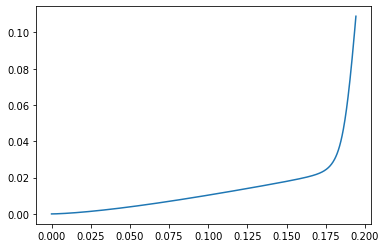

In [28]:
step2 = np.arange(1500)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(step2*deltay,err5)

## 3点平均の場合は、deltay=0.0006の場合に約150ステップ目で発散、0.0003の場合は約420、0.00015の場合は約900で発散する
### 一応、deltayを小さくしていくごとにグリッド数が多くなっていることを考慮しても発散は遅くなっていっていることがわかる。

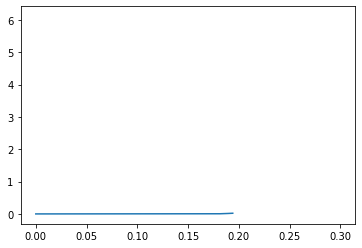

In [29]:
step2 = np.arange(1500)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(step2*deltay,err5_b)